# Predicting Churn of Telco

You are tasked with building a model that can predict which existing subscribers will continue their subscriptions for another month, i.e. the churn of the telco.

The dataset comprises of multiple features related to the demographic of customers for a video store. This data is obtained from [Kaggle|https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data].

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

### Dataset descriptions

- `Customer ID`
- `gender` Whether the customer is a male or a female
- `SeniorCitizen` Whether the customer is a senior citizen or not (1, 0)
- `Partner` Whether the customer has a partner or not (Yes, No)
- `Dependents` Whether the customer has dependents or not (Yes, No)
- `tenure` Number of months the customer has stayed with the company
- `PhoneService` Whether the customer has a phone service or not (Yes, No)
- `MultipleLines` Whether the customer has multiple lines or not (Yes, No, No phone service)
- `InternetService` Customer’s internet service provider (DSL, Fiber optic, No)
- `OnlineSecurity` Whether the customer has online security or not (Yes, No, No internet service)

In [1]:
# Standard libraries
import numpy as np
import pandas as pd

In [2]:
# sklearn modules for data preprocessing:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# sklearn modules for Model selection
from sklearn import svm, tree, linear_model, neighbors
from sklearn import naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
# sklearn modules for Model Evaluation & Improvement:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, recall_score, log_loss
from sklearn.metrics import average_precision_score

In [5]:
# Standard libraries for data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
import matplotlib.ticker as mtick
from IPython.display import display
pd.options.display.max_columns = None
from pandas.plotting import scatter_matrix

## Set up

In [6]:
# Read the training data provided
path='WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(path)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Notice that it has column 'Churn' which is our target variable where 1 indicates a loss of customer and 0 means a retention.
We now look at our testing data.

In [7]:
print("The shape of the dataset set is ", df.shape)

The shape of the dataset set is  (7043, 21)


In [8]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [9]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


We can see that the average userbase is 60 years old, and the average viewing duration is 92 hours.

We also see that the average churn rate is actually 18%.

In [10]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

There are multiply categorical columns we will have to take note of.

__Re-validate column data types and missing values__: Check if there are any missing values that can mess up data accuracy.

In [11]:
df.columns.to_series().groupby(df.dtypes).groups

{int64: ['SeniorCitizen', 'tenure'], float64: ['MonthlyCharges'], object: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']}

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


It looks like there are no empty values in the dataframe.

In [13]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [14]:
(df.dtypes == 'object')

customerID           True
gender               True
SeniorCitizen       False
Partner              True
Dependents           True
tenure              False
PhoneService         True
MultipleLines        True
InternetService      True
OnlineSecurity       True
OnlineBackup         True
DeviceProtection     True
TechSupport          True
StreamingTV          True
StreamingMovies      True
Contract             True
PaperlessBilling     True
PaymentMethod        True
MonthlyCharges      False
TotalCharges         True
Churn                True
dtype: bool

In [15]:
#List of categorical types
object_columns = df.columns[df.dtypes == 'object']
object_columns

Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges',
       'Churn'],
      dtype='object')

We check through all the distribution of the categorical columns.

In [16]:
df['gender'].value_counts()

gender
Male      3555
Female    3488
Name: count, dtype: int64

In [17]:
df['Partner'].value_counts()

Partner
No     3641
Yes    3402
Name: count, dtype: int64

In [18]:
df['Dependents'].value_counts()

Dependents
No     4933
Yes    2110
Name: count, dtype: int64

In [19]:
df['PhoneService'].value_counts()

PhoneService
Yes    6361
No      682
Name: count, dtype: int64

In [20]:
df['MultipleLines'].value_counts()

MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

In [21]:
df['InternetService'].value_counts()

InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

In [22]:
df['OnlineSecurity'].value_counts()

OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

In [23]:
df['OnlineBackup'].value_counts()

OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64

In [24]:
df['DeviceProtection'].value_counts()

DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64

In [25]:
df['TechSupport'].value_counts()

TechSupport
No                     3473
Yes                    2044
No internet service    1526
Name: count, dtype: int64

In [26]:
df['StreamingTV'].value_counts()

StreamingTV
No                     2810
Yes                    2707
No internet service    1526
Name: count, dtype: int64

In [27]:
df['StreamingMovies'].value_counts()

StreamingMovies
No                     2785
Yes                    2732
No internet service    1526
Name: count, dtype: int64

In [28]:
df['Contract'].value_counts()

Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

In [29]:
df['PaperlessBilling'].value_counts()

PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64

In [30]:
df['PaymentMethod'].value_counts()

PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

In [31]:
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

### Cleaning (if any)

#### Cast correct object types

We notice that TotalCharges is an object type even though MonthlyCharges is a float.

In [32]:
df[['MonthlyCharges', 'TotalCharges']].head()

,MonthlyCharges,TotalCharges
0,29.85,29.85
1,56.95,1889.5
2,53.85,108.15
3,42.30,1840.75
4,70.70,151.65


In [33]:
check = pd.to_numeric(df['TotalCharges'], errors='coerce').isna()
len(df[check].TotalCharges)

11

In [34]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].astype('float')

#### Mutable

There is no missing data, and all the columns are in the correct data type.

In [35]:
#Fill missing values in programatically if there is any

na_cols = df.isna().any()
na_cols = na_cols[na_cols == True].reset_index()
na_cols = na_cols.index.to_list()
no_churn = df.columns.to_list()
no_churn.remove('Churn')

simpleImputer = SimpleImputer(strategy="most_frequent") #Choosing mode this time round
impute_X = pd.DataFrame(simpleImputer.fit_transform(df[no_churn]))
    
#Imputation removed column names; put them back
# Also put back the column types because it normally changes that to object
impute_X.columns = df[no_churn].columns
impute_X = impute_X.astype(df[no_churn].dtypes.to_dict())
#Add back churn
impute_X = pd.concat([impute_X, df['Churn']], axis=1)

Re-validate as needed

In [36]:
impute_X.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [37]:
impute_X.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

### Label Encoding

We have explored the categorical columns. Machine Learning algorithms can typically only work with numerical values as independent variables. Having label encoding allows us to encode categorical labels with appropriate numerical values. We will utilise Label encoding and One Hot encoding for the different features.

In [38]:
# Create label encoder
le = LabelEncoder() #Use default values

# Only use label encoder for columns with 2 or less unique
le_count = 0
le_list = []
for col in impute_X[object_columns]:
    if len(list(impute_X[col].unique())) <= 2:
        impute_X[col] = le.fit_transform(impute_X[col])
        le_count += 1
        le_list.append(col)
        
print(f'{le_count} columns were label encoded.')
print(', '.join(le_list))

6 columns were label encoded.
gender, Partner, Dependents, PhoneService, PaperlessBilling, Churn


In [39]:
# We check what they have become for one of the columns
impute_X['PaperlessBilling'].head()

0    1
1    0
2    1
3    0
4    1
Name: PaperlessBilling, dtype: int32

## Exploratory Data Analysis

In [40]:
object_columns = impute_X.columns[impute_X.dtypes == 'object']
object_columns

Index(['customerID', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaymentMethod'],
      dtype='object')

In [41]:
# Try to understand patterns of data by plotting histogram of continuous variables
num_cols = [col for col in impute_X.columns if col not in object_columns]
#num_cols += le_list
num_cols.remove('Churn') #Remove churn
num_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'PaperlessBilling',
 'MonthlyCharges',
 'TotalCharges']

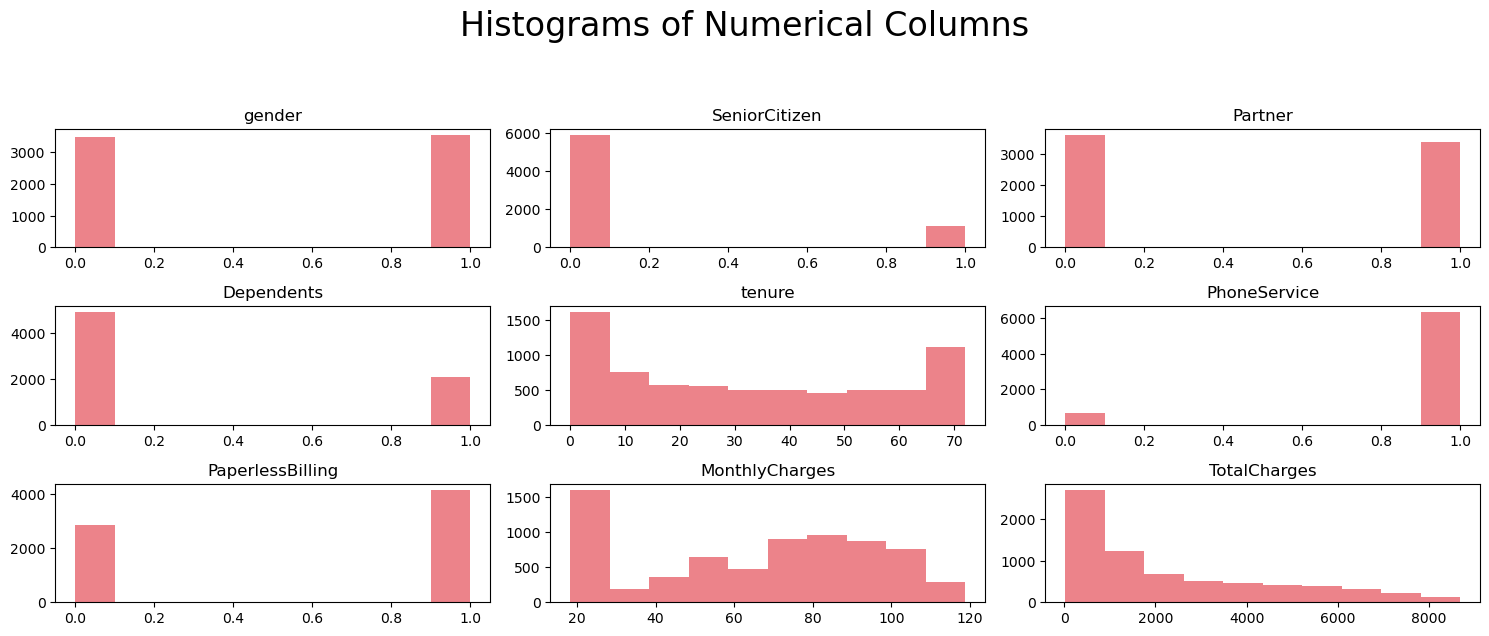

In [42]:
# Plot histogram
num_df = impute_X[num_cols]
fig = plt.figure(figsize=(15,12))

plt.suptitle('Histograms of Numerical Columns', horizontalalignment='center',
            fontsize=24, fontfamily='sans-serif')

for i in range(len(num_cols)): #for each column
    plt.subplot(6, 3, i+1)
    f = plt.gca() #get current axes being worked on
    f.set_title(num_cols[i])
    
    vals = np.size(num_df.iloc[:, i].unique())
    if vals >= 100:
        vals = 100
    
    plt.hist(num_df.iloc[:,i], color='#ec838a')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

A few observations can be made based on the histograms for numerical variables:

- Gender shows an even distribution across all range, with a slight dip in the 50s
- Most of the customers are younger people.
- Not many have dependants while most have a Partner
- Lot more new customers (less than 10 months) followed by a loyal customer segment that stays more than 70 months
- Most seem to have Phone Service and request for Paperless Billing
- Monthly charges span anywhere between $18 to $118 per customer with a huge proportion of customers on $20.

### Analyze the distribution of categorical variables:

In [43]:
#remaining col types not label encoded
oh_cols = [col for col in object_columns.to_list() if col not in le_list]
oh_cols

['customerID',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

__Distribution of contract type__: We investigate if the SubscriptionType has any impact.

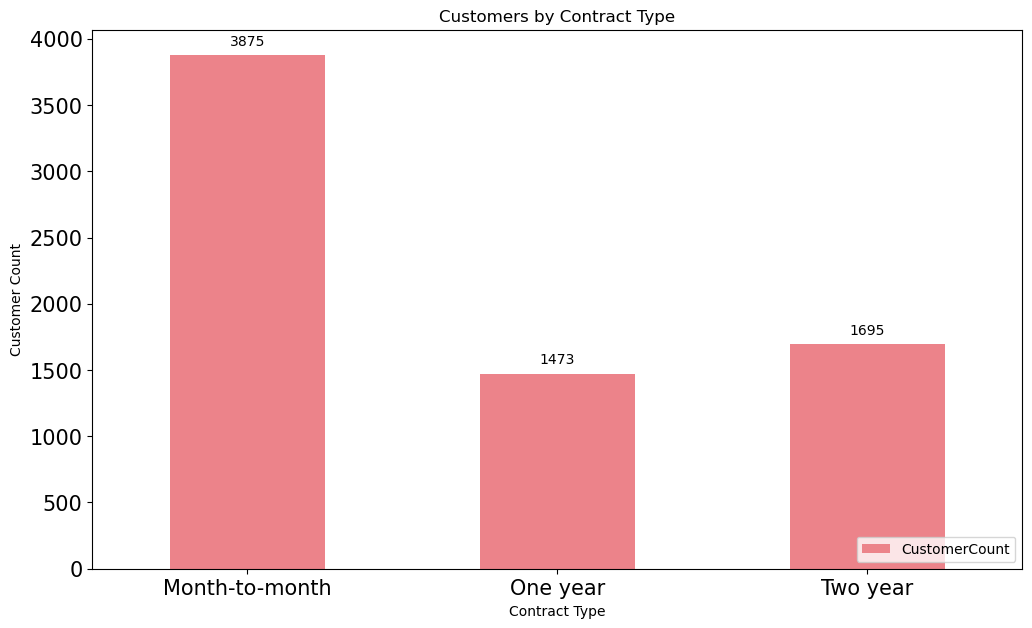

In [44]:
subscription_split = impute_X[['customerID', 'Contract']]
subtype = subscription_split.groupby("Contract")
subscription_split = pd.DataFrame(subtype["customerID"].count())
subscription_split.rename(columns={"customerID":"CustomerCount"}, inplace=True)

fig, ax = plt.subplots(figsize=(12,7))
subscription_split.plot(kind="bar", stacked=False, color='#ec838a', fontsize=15, ax=ax)

ax.set_title("Customers by Contract Type")
ax.set_xlabel("Contract Type")
ax.set_ylabel("Customer Count")

plt.legend(loc='lower right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")

def add_value_labels(ax, spacing=5):   
    for rect in ax.patches:      
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2       
        space = spacing        
        va = 'bottom'      
        if y_value < 0:           
            space *= -1            
            va = 'top'       
        label = "{:.0f}".format(y_value)      
        
        ax.annotate(label,
                    (x_value, y_value),
                    xytext=(0, space),
                    textcoords="offset points",
                    ha='center',
                    va=va
        )  
        
add_value_labels(ax)

plt.show()

__Observations:__
We see that there is more short term contracts customers instead of one year or two year contracts.

### Distribution of payment method type

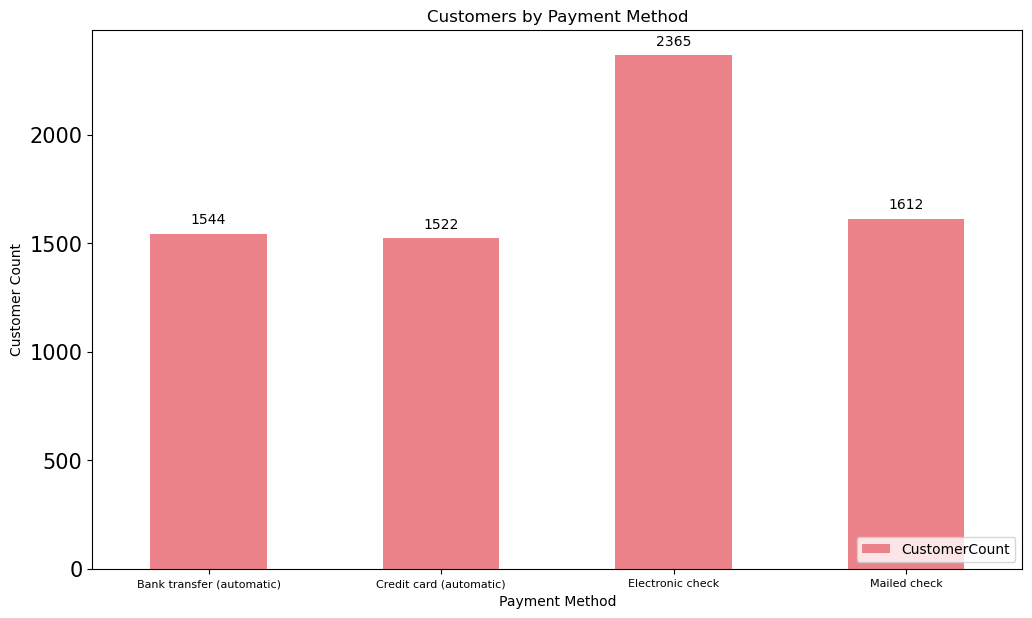

In [45]:
payment_split = impute_X[['customerID', 'PaymentMethod']]
subtype = payment_split.groupby("PaymentMethod")
payment_split = pd.DataFrame(subtype["customerID"].count())
payment_split.rename(columns={"customerID":"CustomerCount"}, inplace=True)

fig, ax = plt.subplots(figsize=(12,7))
payment_split.plot(kind="bar", stacked=False, color='#ec838a', fontsize=15, ax=ax)

ax.set_title("Customers by Payment Method")
ax.set_xlabel("Payment Method")
ax.set_ylabel("Customer Count")

plt.legend(loc='lower right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center", fontsize=8)
plt.yticks(rotation=0, horizontalalignment="right")

def add_value_labels(ax, spacing=5):   
    for rect in ax.patches:      
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2       
        space = spacing        
        va = 'bottom'      
        if y_value < 0:           
            space *= -1            
            va = 'top'       
        label = "{:.0f}".format(y_value)      
        
        ax.annotate(label,
                    (x_value, y_value),
                    xytext=(0, space),
                    textcoords="offset points",
                    ha='center',
                    va=va
        )  
        
add_value_labels(ax)

plt.show()

### Distribution of label encoded categorical variables:

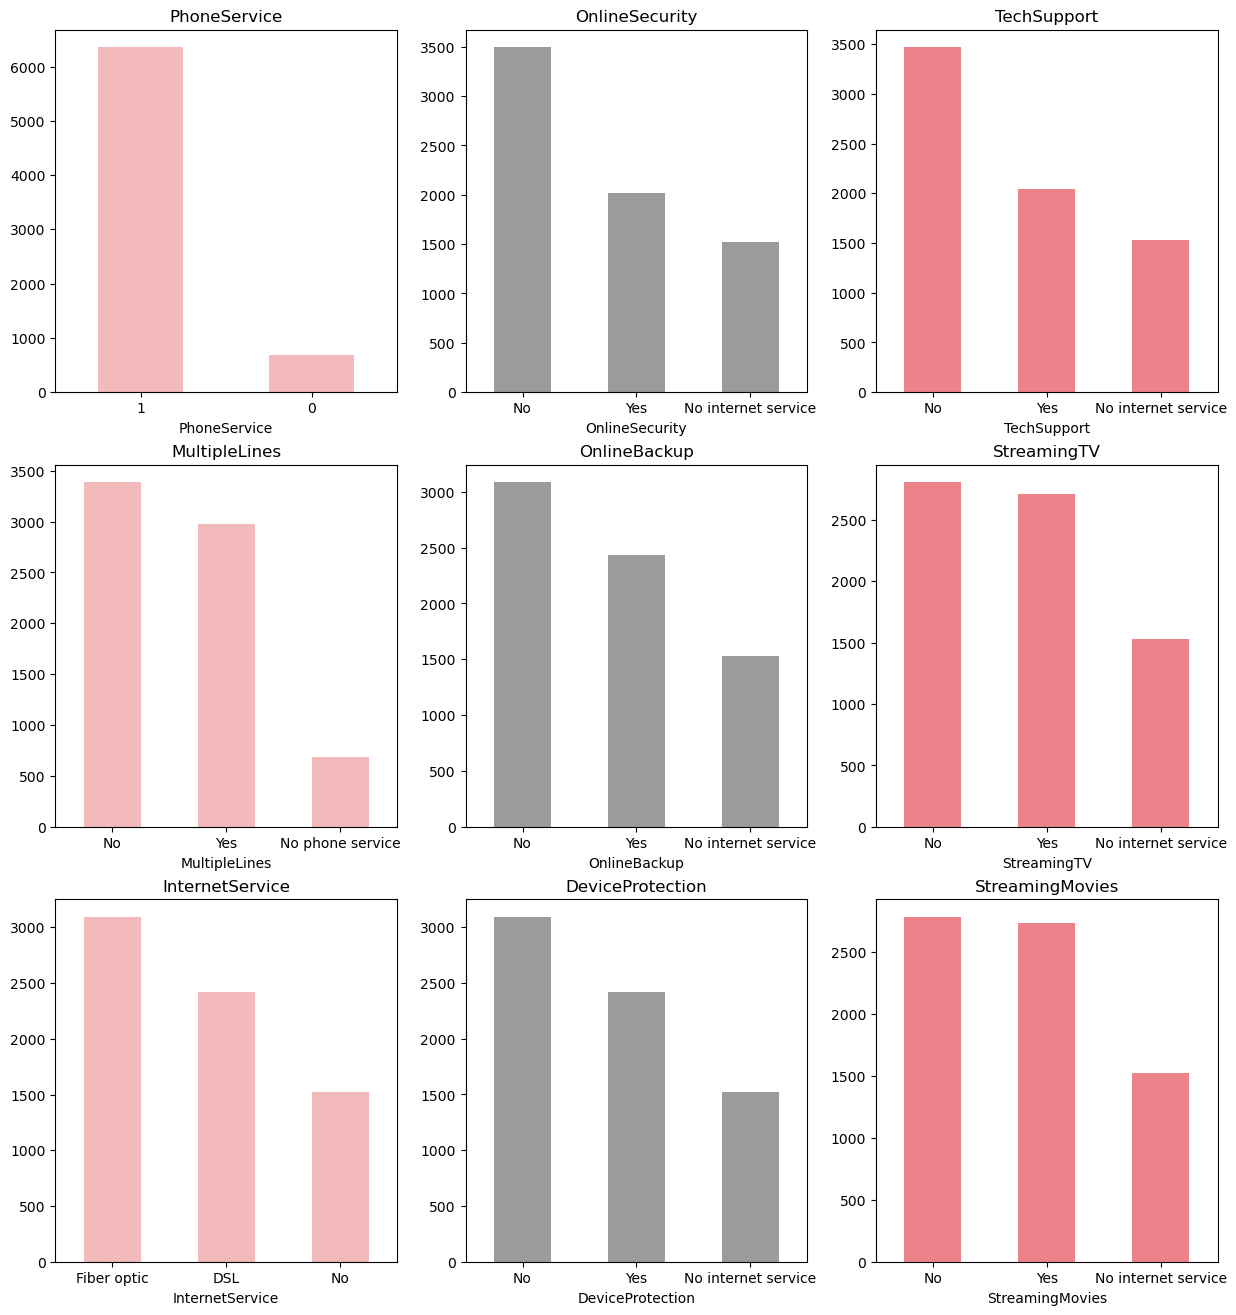

In [46]:
services= ['PhoneService','MultipleLines',
'InternetService','OnlineSecurity',  'OnlineBackup','DeviceProtection',
'TechSupport','StreamingTV','StreamingMovies']

fig, axes = plt.subplots(nrows = 3,ncols = 3,
figsize = (15, 16))
for i, item in enumerate(services):
    if i < 3:
        ax = impute_X[item].value_counts().plot(kind = 'bar',
                                                      ax=axes[i,0],
                                                      rot = 0,
                                                      color ='#f3babc'
                                                     )
    elif i >=3 and i < 6:
        ax = impute_X[item].value_counts().plot(kind = 'bar',
                                                      ax=axes[i-3,1],
                                                      rot = 0,
                                                      color ='#9b9c9a'
                                                     )
    elif i < 9:
        ax = impute_X[item].value_counts().plot(kind = 'bar',
                                                      ax=axes[i-6,2],
                                                      rot = 0,
                                                      color = '#ec838a'
                                                     )
    ax.set_title(item)

__Observations:__
- Most of the customers have phone service out of which almost half have multiple lines.
- 3/4 of the customers have opted for Internet service with Fiber optic and DSL.
- Almost half of the internet users subscribe to Streaming TV and Movies services.
- Customers generally do not purchase Device Protection, Online Backup and Online Security.

### Overall Churn Rate:

C:\Users\Ning\AppData\Local\Temp\ipykernel_4744\313029166.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_rate.loc[:, "churn_label"] = pd.Series(np.where((churn_rate["Churn"] == 0),  "No", "Yes"))


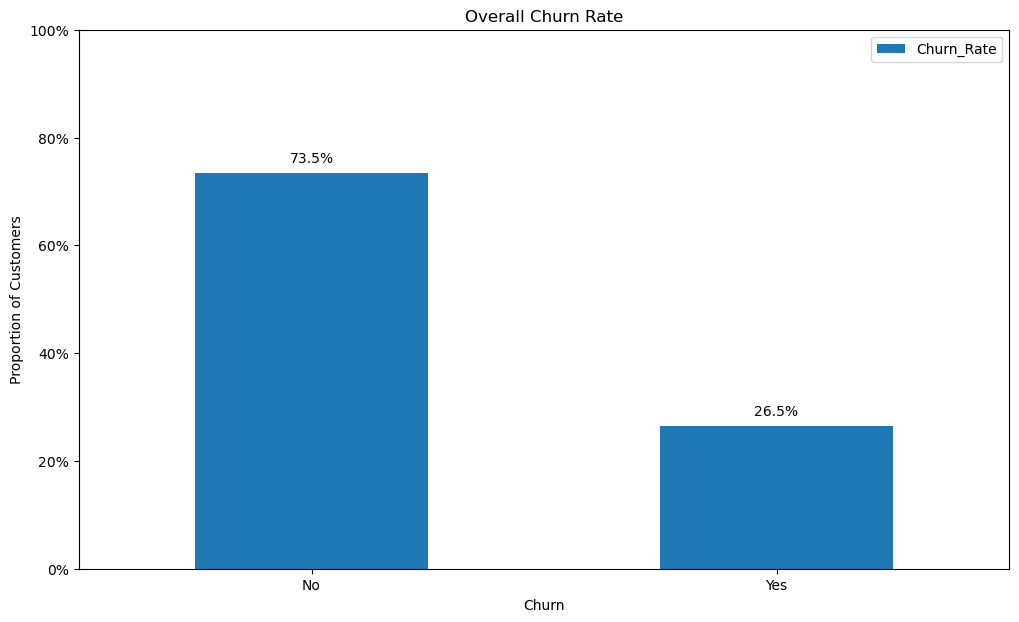

In [47]:
# Analyze the churn rate
from matplotlib.axis import Axis

import matplotlib.ticker as mtick
churn_rate = impute_X[["Churn", "customerID"]]
churn_rate.loc[:, "churn_label"] = pd.Series(np.where((churn_rate["Churn"] == 0),  "No", "Yes"))

sectors = churn_rate.groupby("churn_label")
churn_rate = pd.DataFrame(sectors["customerID"].count())
churn_rate["Churn_Rate"] = churn_rate["customerID"] / sum(churn_rate["customerID"]) * 100

fig, ax = plt.subplots(figsize=(12,7))
churn_rate[["Churn_Rate"]].plot(kind="bar", ax=ax)

ax.set_title("Overall Churn Rate")
ax.set_xlabel("Churn", horizontalalignment="center")
ax.set_ylabel("Proportion of Customers", horizontalalignment="center")

plt.legend(loc='upper right', fontsize="medium")
plt.xticks(rotation=0, horizontalalignment="center")
ax.set_ylim(0, 100)
Axis.set_major_formatter(ax.yaxis, mtick.PercentFormatter())

x_labels=np.array(churn_rate[["customerID"]])

def add_value_labels(ax, spacing=5):   
    for rect in ax.patches:     
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2       
        space = spacing
        va = 'bottom'        
        if y_value < 0:           
            space *= -1          
            va = 'top'
        label = "{:.1f}%".format(y_value)
        
        ax.annotate(label,
                    (x_value, y_value),
                    xytext=(0, space),
                    textcoords="offset points",
                    ha='center',
                    va=va
                   )

add_value_labels(ax)
ax.autoscale(enable=False, axis='both', tight=False)

__Observations:__ We can see that around 73.5% of the customers remain in service. This makes this an imbalanced classification problem. Since the data is skewed, we need to keep in mind while choosing the metrics for model selection.

### Churn rate by Subscription Type:

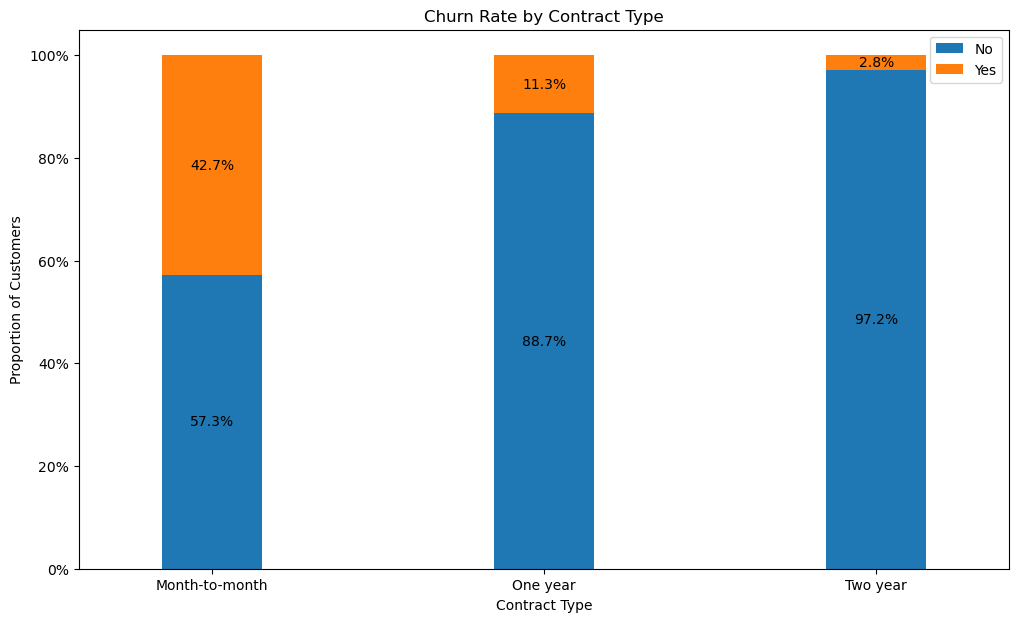

In [48]:
import matplotlib.ticker as mtick
# Get a table of each subscription type and the number of customers registered for each
contract_churn = impute_X[['Contract', 'Churn','customerID']].groupby(['Contract', 'Churn']).size().unstack()
contract_churn.rename(columns={0:'No', 1:'Yes'}, inplace=True)
#Transform into a percentage table
contract_churn_transform = (contract_churn.T*100.0 / contract_churn.T.sum()).T

colors = ['#ec383a', '#9b9c9a']

fig, ax = plt.subplots(figsize=(12,7))

contract_churn_transform.plot(kind='bar', width=0.3, stacked=True, rot=0, ax=ax)

ax.set_ylabel('Proportion of Customers')
ax.set_xlabel('Contract Type')
ax.set_title('Churn Rate by Contract Type')

plt.legend(loc='upper right')
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
Axis.set_major_formatter(ax.yaxis, mtick.PercentFormatter())

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
    
ax.autoscale(enable=False, axis='both', tight=False)

__Observations__: We see that Month-to-Month plans have almost 50% of churn rate compared to the other two types of contract.

### Churn rate by Payment Method Type

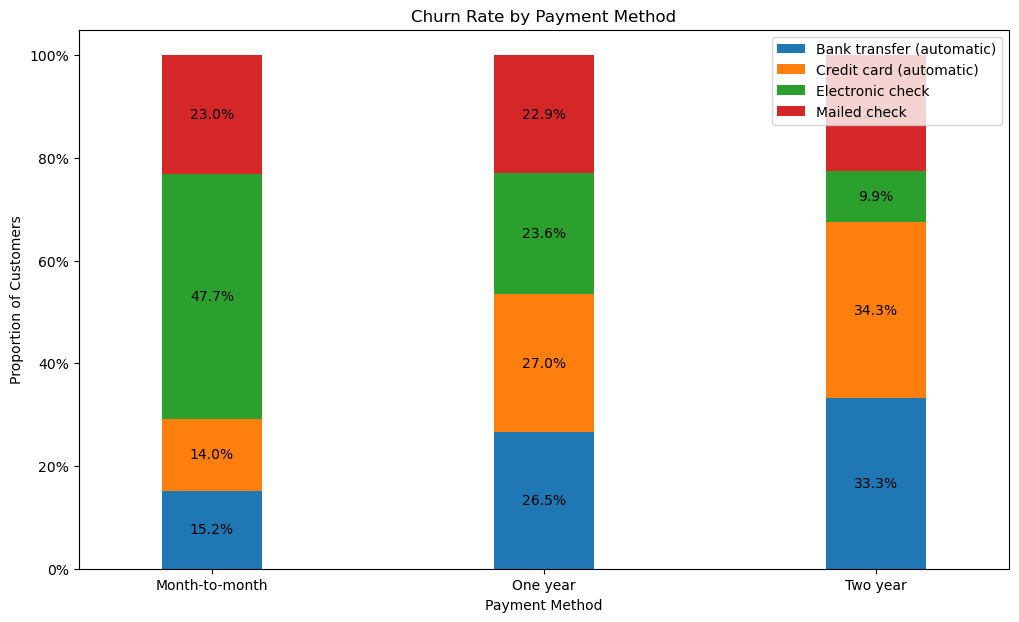

In [49]:
import matplotlib.ticker as mtick
# Get a table of each payment method and the number of customers registered for each
payment_churn = impute_X[['PaymentMethod', 'Contract','customerID']].groupby(['Contract', 'PaymentMethod']).size().unstack()
payment_churn.rename(columns={0:'No', 1:'Yes'}, inplace=True)
#Transform into a percentage table
payment_churn_transform = (payment_churn.T*100.0 / payment_churn.T.sum()).T

colors = ['#ec838a','#9b9c9a', '#f3babc' , '#4d4f4c']

fig, ax = plt.subplots(figsize=(12,7))

payment_churn_transform.plot(kind='bar', width=0.3, stacked=True, rot=0, ax=ax)

ax.set_ylabel('Proportion of Customers')
ax.set_xlabel('Payment Method')
ax.set_title('Churn Rate by Payment Method')

plt.legend(loc='upper right')
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
Axis.set_major_formatter(ax.yaxis, mtick.PercentFormatter())

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
    
ax.autoscale(enable=False, axis='both', tight=False)

__Observations:__ Customers who pay by electronic check has the highest churn rate while those by bank transfer has the lowest.

### Find positive and negative correlations

We look into the positive and negative correlations graphically in the next step.

In [50]:
df2 = impute_X[['SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'PaperlessBilling',
        'MonthlyCharges', 'TotalCharges']]

correlations = df2.corrwith(impute_X.Churn)
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations>0].sort_values(ascending=False)
negative_correlations = correlations[correlations<0].sort_values(ascending=False)

print('Most Positive Correlations: \n', positive_correlations)
print('\nMost Negative Correlations: \n', negative_correlations)

Most Positive Correlations: 
 MonthlyCharges      0.193356
PaperlessBilling    0.191825
SeniorCitizen       0.150889
PhoneService        0.011942
dtype: float64

Most Negative Correlations: 
 Partner        -0.150448
Dependents     -0.164221
TotalCharges   -0.198335
tenure         -0.352229
dtype: float64


#### Plot positive and negative correlations

Text(0.5, 1.0, 'Correlation with Churn Rate \n')

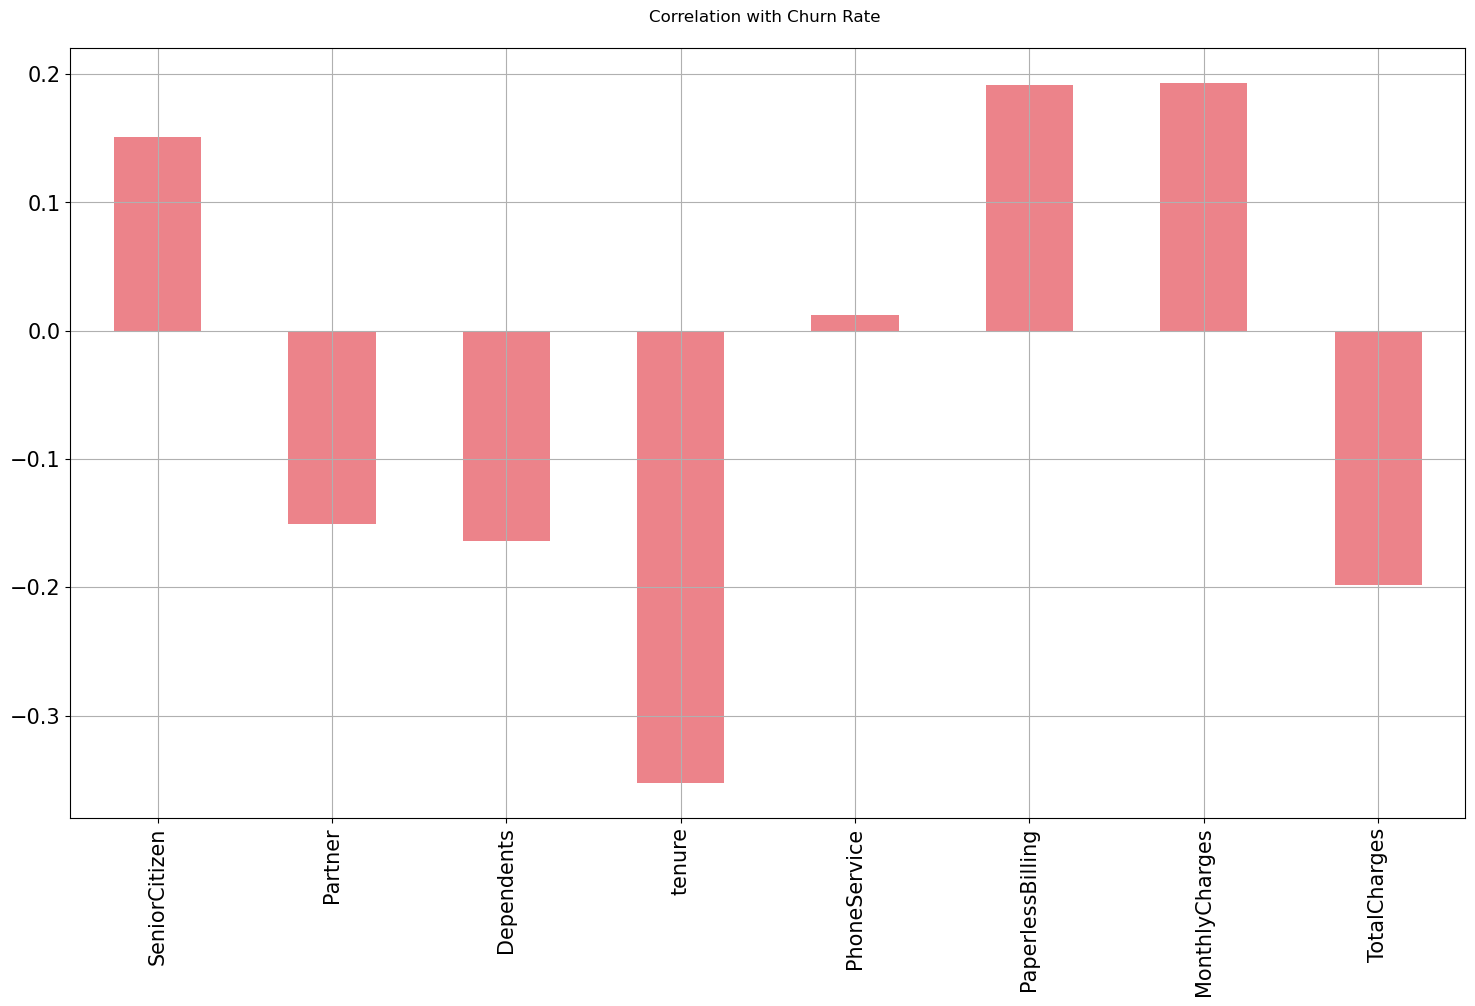

In [51]:
correlations.plot(kind='bar',
                 figsize=(18,10),
                 fontsize=15,
                 color='#ec838a',
                 #rot=45,
                 grid=True)

plt.title('Correlation with Churn Rate \n')

__Observations:__ We can see that there `SeniorCitizen` (i.e. Age), `MonthlyCharges` and `PaperlessBilling` correlate positively with Churn.

Covnersely, `Partner`, `Dependants` and `Tenure` are the features negatively correlated with.

#### Plot positive and negative correlations

We plot the correlation between independent variables to discover the bivariate relationship.

<Axes: >

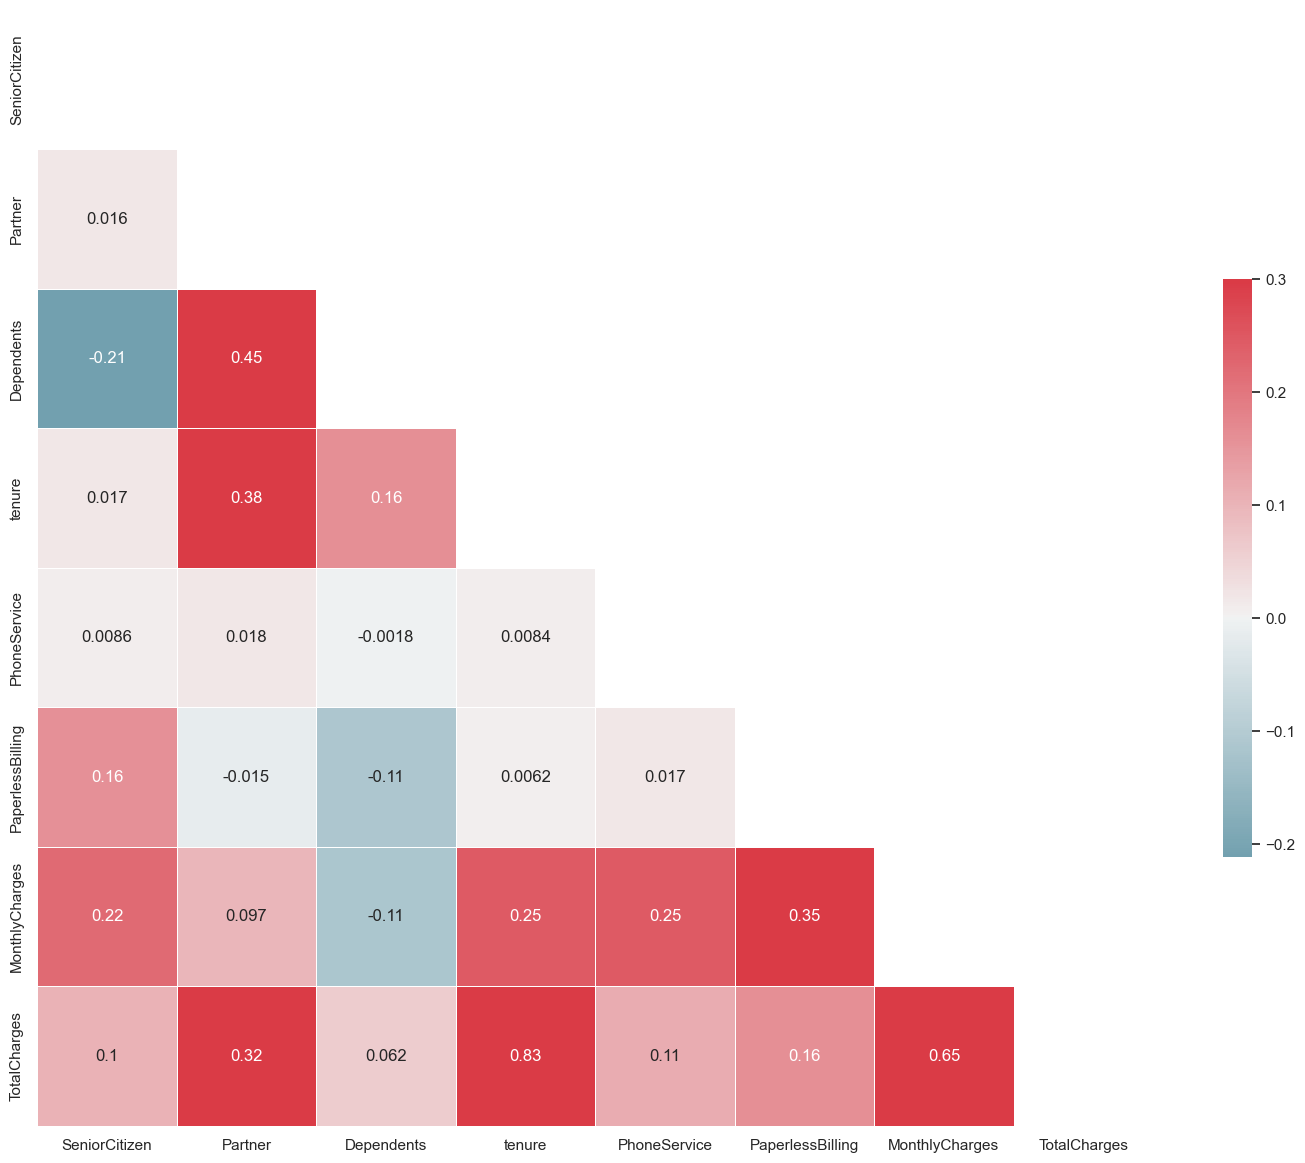

In [52]:
# Set and compute the correlation matrix:
sns.set(style="white")
corr = df2.corr()

#Generate a mast for the upper triangle:
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

#Set up the matplotlib figure and a diverging colormap:

f, ax = plt.subplots(figsize=(18, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0, square=True,
           linewidths=.5, cbar_kws={"shrink":.5}, annot=True)

__Observations:__ We can see the bivariate relationship between `Partner` and `Dependants` which makes sense as you are more likely to have dependants with a partner.

It also appears that with a `Partner`, the `Tenure` will also be positively related. This could be due to the fact that having a Partner implies a stable household to utilise the services.

### Check Multicollinearity using VIF:

Let's try to look into multicollinearity using Variable Inflation Factors (VIF). Unlike Correlation matrix, VIF determines the strength of the correlation of a variable with a group of other independent variables in a dataset. VIF usually starts at 1 and anywhere exceeding 10 indicates high multicollinearity between the independent variables.

In [53]:
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif.sort_values(by=["VIF"], ascending=False)

    return vif

df2 = impute_X[['gender', 
'SeniorCitizen', 'Partner', 'Dependents',
'tenure', 'PhoneService',
'PaperlessBilling','MonthlyCharges',
'TotalCharges']]

calc_vif(df2)

,variables,VIF
0,gender,1.922416
1,SeniorCitizen,1.327817
2,Partner,2.815514
3,Dependents,1.923078
4,tenure,10.693878
5,PhoneService,8.010382
6,PaperlessBilling,2.814044
7,MonthlyCharges,14.056613
8,TotalCharges,12.709667


__Observations:__ We can see that `MonthlyCharges` and `TotalCharges` have high VIF value.

Text(0.5, 1.0, 'Colinearity of Monthly Charges and Total Charges \n')

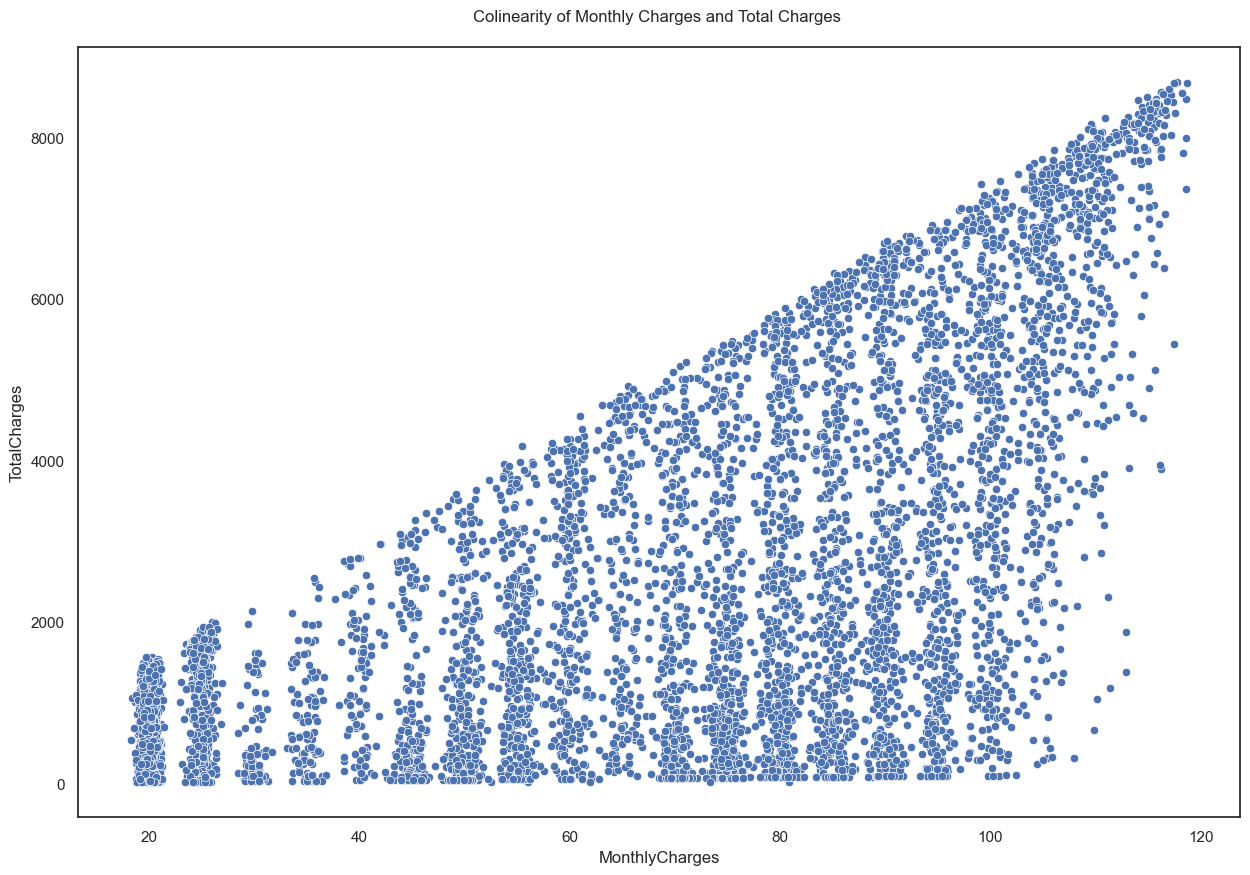

In [54]:
# Check colinearity:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(data=df2, x="MonthlyCharges", y="TotalCharges")

plt.title('Colinearity of Monthly Charges and Total Charges \n')

Let's drop one of the correlated features to see if it helps us in bringing down the multicollinearity between correlated features. Let's drop `TotalCharges` instead.

In [55]:
# Dropping 'MonthlyCharges'
df2 = df2.drop(columns=['TotalCharges'])

#Revalidate Colinearity
calc_vif(df2)

,variables,VIF
0,gender,1.879536
1,SeniorCitizen,1.323089
2,Partner,2.814574
3,Dependents,1.908533
4,tenure,3.287603
5,PhoneService,5.963240
6,PaperlessBilling,2.745897
7,MonthlyCharges,7.453993


__Observations:__ After dropping `TotalCharges`, we can see that VIF values have decreased considerably.

In [56]:
# Apply dropping of `TotalCharges` to main dataset
dataset = impute_X.drop(columns=["TotalCharges"])

### Exploratory Data Analysis Concluding Remarks:

Summary:

- The dataset did not have any missing values (although we will impute with SimpleImputer the most frequent value if any)

- Strongest positive correlation with target feature is `SeniorCitizen` (age) and `MonthlyCharges`

- The dataset is imbalanced with majority of customers being active.

- There is multicolinearity between `MonthlyCharges` and `TotalCharges`. Dropping `TotalCharges` decreased the VIF values considerably.

- Most of the dataset are younger people.

- Most of the customer base lies in `Month-to-Month` subscriptions. They are also more likely to churn if they pay by electronic checks.

### Encode Categorical Data

One-hot encode the remaining categorical data

In [57]:
#Drop the customer ID
identity = dataset['customerID']
dataset = dataset.drop(columns=['customerID'])

#Convert the rest into dummy variables
dataset = pd.get_dummies(dataset)

#Rejoin CustomerID to dataset
dataset = pd.concat([dataset, identity], axis=1)

In [58]:
dataset.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,customerID
0,0,0,1,0,1,0,1,29.85,0,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,7590-VHVEG
1,1,0,0,0,34,1,0,56.95,0,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,5575-GNVDE
2,1,0,0,0,2,1,1,53.85,1,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,True,3668-QPYBK
3,1,0,0,0,45,0,0,42.30,0,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,False,False,7795-CFOCW
4,0,0,0,0,2,1,1,70.70,1,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,9237-HQITU


## Train / Test Split Data

In [59]:
# Set target variable
y = dataset['Churn']
X = dataset.drop(columns=['Churn', 'customerID'])

In [60]:
#split into Train and Testing set
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

#to resolve any class imbalance - use stratify parameter.print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions train_X dataset: ", train_X.shape)
print("Number transactions train_y dataset: ", train_y.shape)
print("Number transactions test_X dataset: ", test_X.shape)
print("Number transactions tesy_y dataset: ", test_y.shape)

Number transactions train_X dataset:  (5634, 39)
Number transactions train_y dataset:  (5634,)
Number transactions test_X dataset:  (1409, 39)
Number transactions tesy_y dataset:  (1409,)


In [61]:
train_X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2142,0,0,0,1,21,1,0,64.85,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,False,False,True,False,True,False,False,False,False,True
1623,0,0,0,0,54,1,1,97.20,False,False,True,False,True,False,True,False,False,False,False,True,True,False,False,True,False,False,False,False,True,False,False,True,False,False,True,True,False,False,False
6074,1,0,1,0,1,0,1,23.45,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False
1362,1,0,0,0,4,1,1,70.20,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False
6754,1,0,0,1,0,1,1,61.90,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,False,False,True,True,False,False,False


In [62]:
train_X_sample = train_X.sample(frac=0.1, random_state=42)
train_y_sample = train_y.loc[train_X_sample.index]

print(f"Train_X sample is ", train_X_sample.shape)
print(f"Train_y sample is ", train_y_sample.shape)

Train_X sample is  (563, 39)
Train_y sample is  (563,)


### Conduct Feature scaling

In [63]:
# Declare StandardScaler variable
sc_X = StandardScaler()
train_X_scaled = sc_X.fit_transform(train_X)

In [64]:
train_X_scaled.shape

(5634, 39)

### PCA (Principal Component Analysis to reduce dimensionality of results) 

In [65]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95) #this keeps 95% of the variance
X_train_pca = pca.fit_transform(train_X_scaled)

# Check how many components were retained
print(f'Number of components selected: {pca.n_components_}')

Number of components selected: 18


The explained variance ratio gives you the amount of variance explained by each principal component. You can visualize this to understand how much information each component captures.

In [66]:
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by each component: {explained_variance}')

Explained variance by each component: [0.28127608 0.13201879 0.09046083 0.05094794 0.0426284  0.03514698
 0.03382023 0.03300499 0.03255013 0.03077441 0.02986979 0.02845359
 0.02595087 0.02557195 0.02389568 0.02291491 0.02171477 0.01991521]


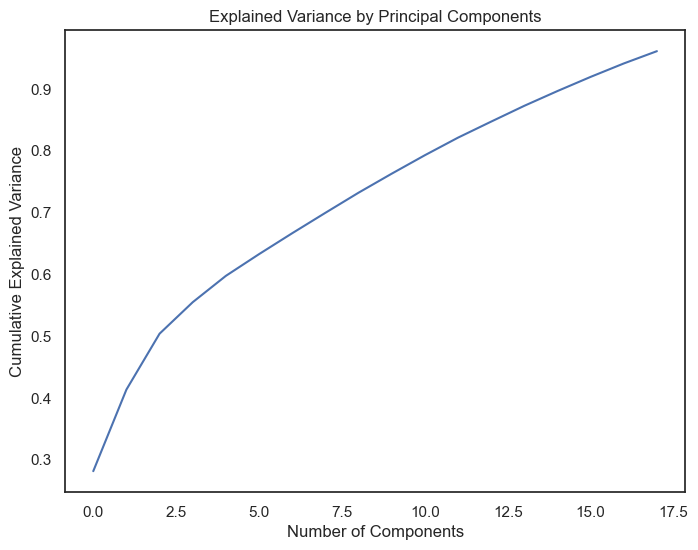

In [67]:
# Plot the cumulative explained ratio

# Plot explained variance ratio to visualize the variance captured by each component
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.show()

#### Examine the Principal Components

The components_ attribute of the PCA object shows the loadings or the combination of original features that make up each principal component. These are the linear combinations of the original features that define the principal components.

In [68]:
# Create a DataFrame with the components and original feature names
component_df = pd.DataFrame(pca.components_, columns=train_X.columns)

# Display the contribution of each original feature to the first principal component
print(component_df.iloc[0].sort_values(ascending=False))

TechSupport_No internet service            0.298404
StreamingMovies_No internet service        0.298404
DeviceProtection_No internet service       0.298404
OnlineSecurity_No internet service         0.298404
InternetService_No                         0.298404
StreamingTV_No internet service            0.298404
OnlineBackup_No internet service           0.298404
PaymentMethod_Mailed check                 0.117854
MultipleLines_No                           0.112268
Contract_Two year                          0.077024
Dependents                                 0.055224
PhoneService                               0.045500
Contract_One year                          0.018416
PaymentMethod_Credit card (automatic)      0.005832
Partner                                    0.003558
gender                                     0.001874
PaymentMethod_Bank transfer (automatic)   -0.002781
tenure                                    -0.010543
MultipleLines_No phone service            -0.045500
SeniorCitize

In [69]:
# we plot to see the weightage of all the features for each component found
component_df.index = [f'PC{i+1}' for i in range(pca.n_components_)]
component_df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
PC1,0.001874,-0.072048,0.003558,0.055224,-0.010543,0.045500,-0.116642,-0.241967,0.112268,-0.045500,-0.086054,-0.085909,-0.164927,0.298404,-0.169984,0.298404,-0.083444,-0.139286,0.298404,-0.112473,-0.140883,0.298404,-0.111093,-0.168395,0.298404,-0.084912,-0.117262,0.298404,-0.134074,-0.116548,0.298404,-0.134756,-0.081068,0.018416,0.077024,-0.002781,0.005832,-0.107350,0.117854
PC2,-0.008414,-0.025248,0.188728,0.112418,0.350162,0.017856,-0.006981,0.155427,-0.157319,-0.017856,0.169659,0.006970,-0.000855,-0.007022,-0.167851,-0.007022,0.192157,-0.185912,-0.007022,0.199260,-0.229196,-0.007022,0.245890,-0.199930,-0.007022,0.226855,-0.204234,-0.007022,0.211114,-0.209895,-0.007022,0.216252,-0.316284,0.115242,0.258619,0.105521,0.122052,-0.123248,-0.085629
PC3,0.007633,-0.124674,0.007971,0.083566,0.017480,-0.365421,-0.130564,-0.230897,0.007489,0.365421,-0.227288,0.431062,-0.362275,-0.060685,-0.118705,-0.060685,0.186603,0.014728,-0.060685,0.037005,0.039942,-0.060685,0.010779,-0.093785,-0.060685,0.158463,0.180555,-0.060685,-0.130173,0.176306,-0.060685,-0.125518,-0.107550,0.052577,0.075016,0.028880,0.057234,-0.166957,0.103083
PC4,0.017272,0.110785,-0.090110,-0.120840,-0.050504,-0.444706,0.084211,-0.078507,-0.233117,0.444706,-0.031903,0.014735,-0.053779,0.047907,0.175059,0.047907,-0.237342,0.052172,0.047907,-0.095515,-0.131516,0.047907,0.096105,0.069393,0.047907,-0.119974,-0.277572,0.047907,0.238428,-0.282764,0.047907,0.242971,0.075392,-0.032781,-0.056520,-0.081101,-0.069321,0.189349,-0.064814
PC5,-0.006241,-0.124345,-0.169772,-0.068877,-0.176175,0.137256,-0.031129,0.082485,0.477019,-0.137256,-0.399351,0.086451,-0.047979,-0.041965,-0.010344,-0.041965,0.049639,0.198360,-0.041965,-0.169970,-0.114263,-0.041965,0.155906,-0.178560,-0.041965,0.234978,-0.195399,-0.041965,0.231733,-0.184757,-0.041965,0.220518,-0.015412,0.159668,-0.136113,-0.093413,-0.093191,0.000307,0.183658
PC6,-0.039226,0.118588,-0.156550,-0.199260,-0.018440,-0.035859,0.035037,0.010871,0.122401,0.035859,-0.145210,-0.013918,0.010698,0.003166,0.029388,0.003166,-0.035406,-0.539019,0.003166,0.557442,-0.004597,0.003166,0.002068,0.081714,0.003166,-0.092987,0.028693,0.003166,-0.031499,0.014858,0.003166,-0.017558,-0.060640,0.384466,-0.300234,-0.015324,-0.101486,0.044094,0.065407
PC7,0.080237,0.012485,0.260324,0.236170,0.073654,-0.017771,-0.023053,-0.039277,0.014993,0.017771,-0.025831,-0.044149,0.041797,0.000548,0.057593,0.000548,-0.064239,0.247236,0.000548,-0.257411,-0.060394,0.000548,0.062715,0.215169,0.000548,-0.237791,0.034724,0.000548,-0.035349,0.040015,0.000548,-0.040561,-0.274796,0.626520,-0.283466,0.074406,0.148739,-0.046880,-0.167142
PC8,-0.013816,-0.001570,-0.073540,-0.107618,0.018415,-0.003819,-0.024639,-0.004829,-0.080523,0.003819,0.079047,0.010562,-0.012963,0.003447,-0.009833,0.003447,0.007745,0.081450,0.003447,-0.087618,0.068461,0.003447,-0.074617,-0.042907,0.003447,0.044193,-0.013998,0.003447,0.011153,-0.022131,0.003447,0.019271,-0.035282,0.081298,-0.037222,0.731223,-0.619365,-0.106877,0.007878
PC9,-0.002882,-0.161296,0.460344,0.551628,-0.014680,-0.026538,0.028880,-0.000287,0.191875,0.026538,-0.209787,0.023688,-0.011144,-0.013917,0.086533,-0.013917,-0.0

In [70]:
min_components = pca.n_components_
train_X_pca = pca.transform(train_X)[:, :min_components] # Transform all features to 18 PCA components
test_X_pca = pca.transform(test_X)[:, :min_components] # Do the same for test data

H:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
H:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


## Model Selection

### Compare Baseline classification Algorithms (1st iteration)

Let's model each classification algorithm over the training dataset and evaluate their accuracy and standard deviation scores.
Classification accuracy is one of the most common classification evaluation metrics to compare baseline algorithms as its the number of correct predictions made as a ratio of total predictions. However, it's not the ideal metric when we have class imbalance issue. Hence let us sort the results based on the 'Mean AUC' value which is nothing but the model's ability to discriminate betwene positive and negative classes.

Models used:
- Logistic Regression
- Support Vector Machine (Kernel = 'Linear' and 'RBF')
- K-Neighbors Classifier
- Gaussian Naive Bayes
- Decision Tree Classifier
- Random Forest Classifier

In [71]:
# Define collection of models
model_results = {}

# Define the K-Fold cross-validator
kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

In [72]:
#Define Logistic Regression model
lr = LogisticRegression(solver='liblinear', random_state=0, class_weight='balanced')

#Perform cross-validation
lr_acc_scores = model_selection.cross_val_score(lr, train_X_scaled, train_y, cv=kfold, scoring='accuracy')
lr_auc_scores = model_selection.cross_val_score(lr, train_X_scaled, train_y, cv=kfold, scoring='roc_auc')

# Print the scores
print("Cross-validation accuracy scores:", lr_acc_scores)
print("Mean cross-validation accuracy score:", lr_acc_scores.mean())
print("Cross-validation ROC AUC scores:", lr_auc_scores)
print("Mean cross-validation ROC AUC score:", lr_auc_scores.mean())

Cross-validation accuracy scores: [0.75066548 0.74800355 0.72582076 0.75066548 0.75843694]
Mean cross-validation accuracy score: 0.7467184448881877
Cross-validation ROC AUC scores: [0.83877787 0.83644164 0.82850899 0.83614199 0.85483878]
Mean cross-validation ROC AUC score: 0.8389418547145228


In [73]:
#Define Logistic Regression model
lr = LogisticRegression(solver='liblinear', random_state=0, class_weight='balanced')

#Perform cross-validation
lr_acc_scores = model_selection.cross_val_score(lr, train_X_pca, train_y, cv=kfold, scoring='accuracy')
lr_auc_scores = model_selection.cross_val_score(lr, train_X_pca, train_y, cv=kfold, scoring='roc_auc')

# Print the scores
print("Cross-validation accuracy scores:", lr_acc_scores)
print("Mean cross-validation accuracy score:", lr_acc_scores.mean())
print("Cross-validation ROC AUC scores:", lr_auc_scores)
print("Mean cross-validation ROC AUC score:", lr_auc_scores.mean())

Cross-validation accuracy scores: [0.7595386  0.7515528  0.74001775 0.74889086 0.76554174]
Mean cross-validation accuracy score: 0.7531083481349912
Cross-validation ROC AUC scores: [0.83873001 0.8322546  0.82337417 0.83065394 0.84873552]
Mean cross-validation ROC AUC score: 0.8347496476049804


In [74]:
# #Create GridSearch for SVM hyperparameters
# parameters = {
#     'kernel': ('linear', 'rbf', 'poly', 'sigmoid'),
#     'C': np.logspace(-3, 3, 5),
#     'gamma': np.logspace(-3, 3, 5)
# }

In [75]:
# svm_cv = GridSearchCV(estimator=SVC(), param_grid=parameters, cv=kfold, scoring='accuracy', n_jobs=-1)
# svm_cv.fit(train_X_pca, train_y)

In [76]:
# Set table to populate with performance results
col = ['ROC AUC Mean', 'ROC AUC STD', 'Accuracy Mean', 'Accuracy STD']
#algo = ['LogisticRegression', 'Linear_SVM', 'RBF_SVM', 'KNN', 'GaussianNaiveBayes', 'DecisionTree', 'RandomForest']
# Storage
results_dict = {}

In [77]:
#Define SVM Linear model
svm_linear = SVC(kernel='linear', random_state=0)

#Perform cross-validation
svml_acc_scores = model_selection.cross_val_score(svm_linear, train_X_pca, train_y, cv=kfold, scoring='accuracy')
svml_auc_scores = model_selection.cross_val_score(svm_linear, train_X_pca, train_y, cv=kfold, scoring='roc_auc')

# Print the scores
print("Cross-validation accuracy scores:", svml_acc_scores)
print("Mean cross-validation accuracy score:", svml_acc_scores.mean())
print("Cross-validation ROC AUC scores:", svml_auc_scores)
print("Mean cross-validation ROC AUC score:", svml_auc_scores.mean())

Cross-validation accuracy scores: [0.81100266 0.79769299 0.78349601 0.78615794 0.80817052]
Mean cross-validation accuracy score: 0.7973040231615081
Cross-validation ROC AUC scores: [0.83765705 0.83354908 0.82095404 0.82942393 0.84707698]
Mean cross-validation ROC AUC score: 0.8337322174759254


In [78]:
#Define SVM RBF model
svm_rbf = SVC(kernel='rbf', random_state=0)

#Perform cross-validation
svmr_acc_scores = model_selection.cross_val_score(svm_rbf, train_X_pca, train_y, cv=kfold, scoring='accuracy')
svmr_auc_scores = model_selection.cross_val_score(svm_rbf, train_X_pca, train_y, cv=kfold, scoring='roc_auc')

# Print the scores
print("Cross-validation accuracy scores:", svmr_acc_scores)
print("Mean cross-validation accuracy score:", svmr_acc_scores.mean())
print("Cross-validation ROC AUC scores:", svmr_auc_scores)
print("Mean cross-validation ROC AUC score:", svmr_auc_scores.mean())

Cross-validation accuracy scores: [0.7826087  0.79591837 0.78615794 0.78083407 0.80373002]
Mean cross-validation accuracy score: 0.7898498189916171
Cross-validation ROC AUC scores: [0.80047465 0.80420602 0.79521228 0.79510502 0.83088256]
Mean cross-validation ROC AUC score: 0.805176107620994


In [79]:
#Define K Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors = 5, metric="minkowski")

#Perform cross-validation
knn_acc_scores = model_selection.cross_val_score(knn, train_X_pca, train_y, cv=kfold, scoring='accuracy')
knn_auc_scores = model_selection.cross_val_score(knn, train_X_pca, train_y, cv=kfold, scoring='roc_auc')

# Print the scores
print("Cross-validation accuracy scores:", knn_acc_scores)
print("Mean cross-validation accuracy score:", knn_acc_scores.mean())
print("Cross-validation ROC AUC scores:", knn_auc_scores)
print("Mean cross-validation ROC AUC score:", knn_auc_scores.mean())

Cross-validation accuracy scores: [0.77994676 0.77018634 0.76042591 0.75865129 0.77619893]
Mean cross-validation accuracy score: 0.7690818454186833
Cross-validation ROC AUC scores: [0.77955806 0.77012776 0.78186573 0.76682453 0.79298722]
Mean cross-validation ROC AUC score: 0.7782726600331771


In [80]:
#Define Gaussian Naive Bayes
gauss_nb = GaussianNB()

#Perform cross-validation
gauss_nb_acc_scores = model_selection.cross_val_score(gauss_nb, train_X_pca, train_y, cv=kfold, scoring='accuracy')
gauss_nb_auc_scores = model_selection.cross_val_score(gauss_nb, train_X_pca, train_y, cv=kfold, scoring='roc_auc')

# Print the scores
print("Cross-validation accuracy scores:", gauss_nb_acc_scores)
print("Mean cross-validation accuracy score:", gauss_nb_acc_scores.mean())
print("Cross-validation ROC AUC scores:", gauss_nb_auc_scores)
print("Mean cross-validation ROC AUC score:", gauss_nb_auc_scores.mean())

Cross-validation accuracy scores: [0.7054126  0.68411713 0.6743567  0.72670807 0.70071048]
Mean cross-validation accuracy score: 0.698260995648549
Cross-validation ROC AUC scores: [0.77908739 0.78575013 0.7914348  0.80682931 0.80157623]
Mean cross-validation ROC AUC score: 0.792935572268668


In [81]:
#Define Decision Tree Classifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)

#Perform cross-validation
tree_acc_scores = model_selection.cross_val_score(tree, train_X_pca, train_y, cv=kfold, scoring='accuracy')
tree_auc_scores = model_selection.cross_val_score(tree, train_X_pca, train_y, cv=kfold, scoring='roc_auc')

# Print the scores
print("Cross-validation accuracy scores:", tree_acc_scores)
print("Mean cross-validation accuracy score:", tree_acc_scores.mean())
print("Cross-validation ROC AUC scores:", tree_auc_scores)
print("Mean cross-validation ROC AUC score:", tree_auc_scores.mean())

Cross-validation accuracy scores: [0.7826087  0.7826087  0.77994676 0.77284827 0.78507993]
Mean cross-validation accuracy score: 0.7806184702624581
Cross-validation ROC AUC scores: [0.7914084  0.77938101 0.79081584 0.78826748 0.7954277 ]
Mean cross-validation ROC AUC score: 0.789060086750884


In [82]:
# Define Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)

#Perform cross-validation
random_forest_acc_scores = model_selection.cross_val_score(random_forest, train_X_pca, train_y, cv=kfold, scoring='accuracy')
random_forest_auc_scores = model_selection.cross_val_score(random_forest, train_X_pca, train_y, cv=kfold, scoring='roc_auc')

# Print the scores
print("Cross-validation accuracy scores:", random_forest_acc_scores)
print("Mean cross-validation accuracy score:", random_forest_acc_scores.mean())
print("Cross-validation ROC AUC scores:", random_forest_auc_scores)
print("Mean cross-validation ROC AUC score:", random_forest_auc_scores.mean())

Cross-validation accuracy scores: [0.7755102  0.79591837 0.78438332 0.77994676 0.79662522]
Mean cross-validation accuracy score: 0.7864767746622936
Cross-validation ROC AUC scores: [0.80015556 0.81525342 0.80453257 0.7981918  0.8195403 ]
Mean cross-validation ROC AUC score: 0.807534730062347


In [83]:
# Evaluating Model Results:

results_dict['LinearRegression'] = [lr_auc_scores.mean(), lr_auc_scores.std(), lr_acc_scores.mean(), lr_acc_scores.std()]
results_dict['Linear_SVM'] = [svml_auc_scores.mean(), svml_auc_scores.std(), svml_acc_scores.mean(), svml_acc_scores.std()]
results_dict['RBF_SVM'] = [svmr_auc_scores.mean(), svmr_auc_scores.std(), svmr_acc_scores.mean(), svmr_acc_scores.std()]
results_dict['KNN'] = [knn_auc_scores.mean(), knn_auc_scores.std(), knn_acc_scores.mean(), knn_acc_scores.std()]
results_dict['GaussianNaiveBayes'] = [gauss_nb_auc_scores.mean(), gauss_nb_auc_scores.std(), gauss_nb_acc_scores.mean(), gauss_nb_acc_scores.std()]
results_dict['DecisionTree'] = [tree_auc_scores.mean(), tree_auc_scores.std(), tree_acc_scores.mean(), tree_acc_scores.std()]
results_dict['RandomForest'] = [random_forest_auc_scores.mean(), random_forest_auc_scores.std(), random_forest_acc_scores.mean(), random_forest_acc_scores.std()]

results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=col)
results_df = results_df.apply(lambda x: round(x*100, 2))

results_df

,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
LinearRegression,83.47,0.85,75.31,0.88
Linear_SVM,83.37,0.87,79.73,1.11
RBF_SVM,80.52,1.33,78.98,0.87
KNN,77.83,0.93,76.91,0.84
GaussianNaiveBayes,79.29,1.01,69.83,1.81
DecisionTree,78.91,0.54,78.06,0.42
RandomForest,80.75,0.84,78.65,0.85


### Visualise Classification Algorithms Comparison:

In [84]:
algo = ['LogisticRegression', 'Linear_SVM', 'RBF_SVM', 'KNN', 'GaussianNaiveBayes', 'DecisionTree', 'RandomForest']
acc_scores = [lr_acc_scores, svml_acc_scores, svmr_acc_scores, knn_acc_scores, gauss_nb_acc_scores, tree_acc_scores, random_forest_acc_scores]
auc_scores = [lr_auc_scores, svml_auc_scores, svmr_auc_scores, knn_auc_scores, gauss_nb_auc_scores, tree_auc_scores, random_forest_auc_scores]

(array([0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82]),
 [Text(0, 0.66, '0.66'),
  Text(0, 0.68, '0.68'),
  Text(0, 0.7000000000000001, '0.70'),
  Text(0, 0.72, '0.72'),
  Text(0, 0.74, '0.74'),
  Text(0, 0.76, '0.76'),
  Text(0, 0.78, '0.78'),
  Text(0, 0.8, '0.80'),
  Text(0, 0.8200000000000001, '0.82')])

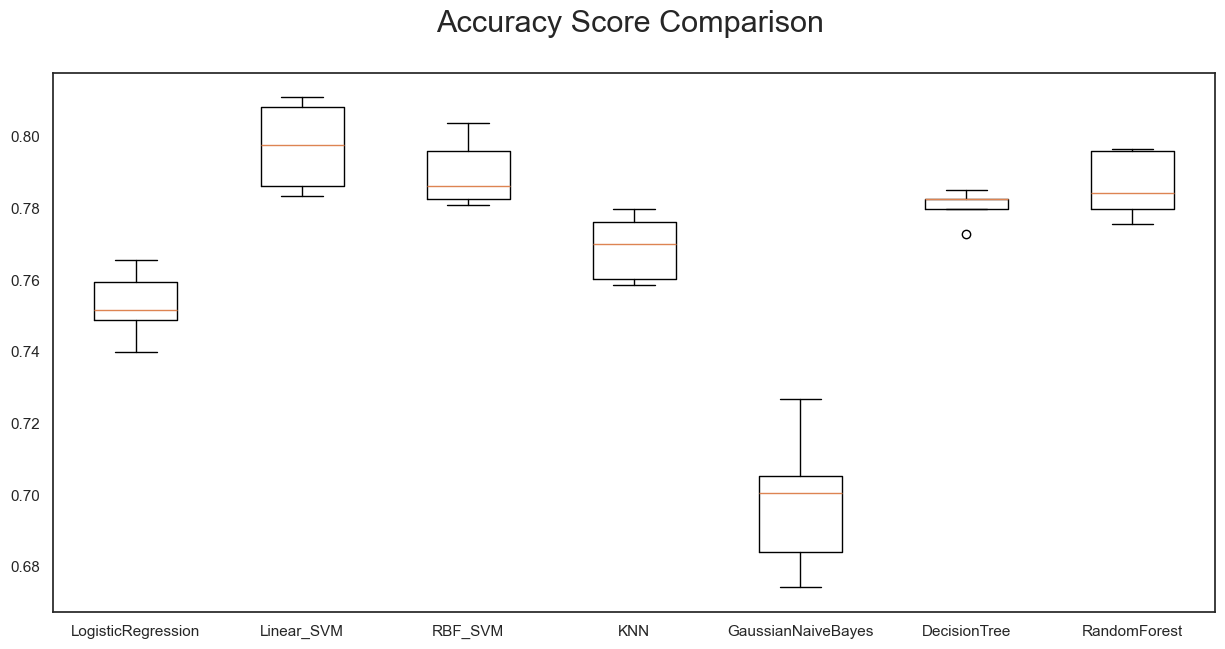

In [85]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)

plt.boxplot(acc_scores)

ax.set_xticklabels(algo)

plt.title('Accuracy Score Comparison \n', horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")

(array([0.76, 0.78, 0.8 , 0.82, 0.84, 0.86]),
 [Text(0, 0.76, '0.76'),
  Text(0, 0.78, '0.78'),
  Text(0, 0.8, '0.80'),
  Text(0, 0.8200000000000001, '0.82'),
  Text(0, 0.84, '0.84'),
  Text(0, 0.86, '0.86')])

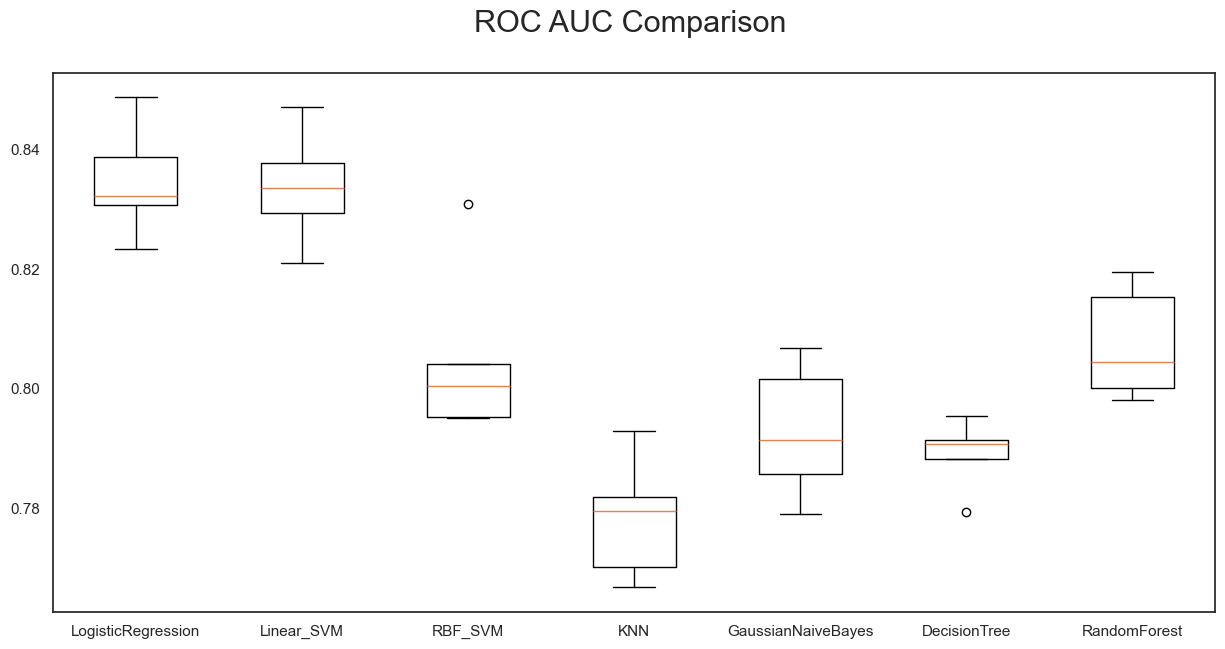

In [86]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)

plt.boxplot(auc_scores)

ax.set_xticklabels(algo)

plt.title('ROC AUC Comparison \n', horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")

__Observations:__ We can see that from the first iteration of baseline classification algorithms, `Logistic Regression` and `Linear SVC` has outperformed the other models.

### Further Iteration

Let's optimise the parameters and finalise the evaluation metrics for model selection.

We tested with K=5 for K-Nearest Neighbors, but in reality, we do not know the optimal K value that gives us maximum accuracy. Therefore, write a loop to iterate 20 to 30 times and give the accuracy at each iteration to figure out the optimal number of K neighbors for KNN.

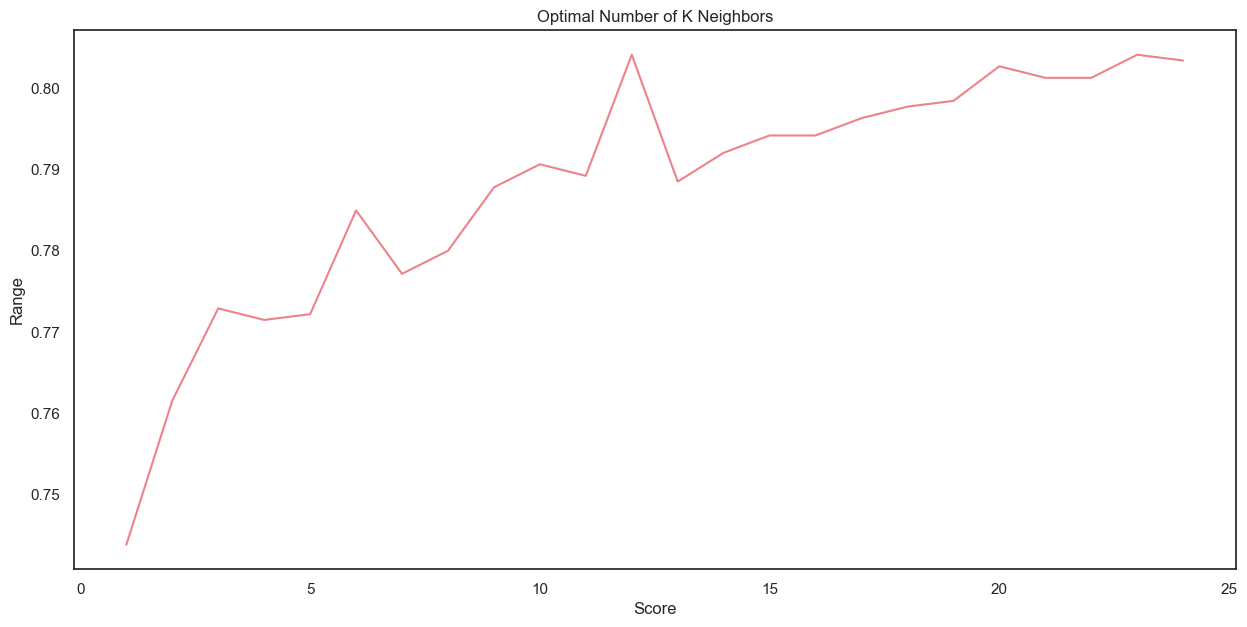

The most optimal K is 12 with a value of 0.8041163946061036


In [87]:
score_array = []
for i in range(1, 25):
    knn_loop = KNeighborsClassifier(n_neighbors = i)
    
    knn_loop.fit(train_X_pca, train_y)
    score_array.append(knn_loop.score(test_X_pca, test_y))
    
# Plot the accuracy results
fig = plt.figure(figsize=(15,7))
plt.plot(range(1, 25), score_array, color='#ec838a')

plt.ylabel('Range')
plt.xlabel('Score')
plt.title('Optimal Number of K Neighbors')

plt.show()
print(f"The most optimal K is {score_array.index(max(score_array))+1} with a value of {max(score_array)}")

__Observations:__ From the above iterations, we find that if we use K=12, we will get the maximum score of 0.80411

We do the same for random forest, to find the optimal number of decision trees

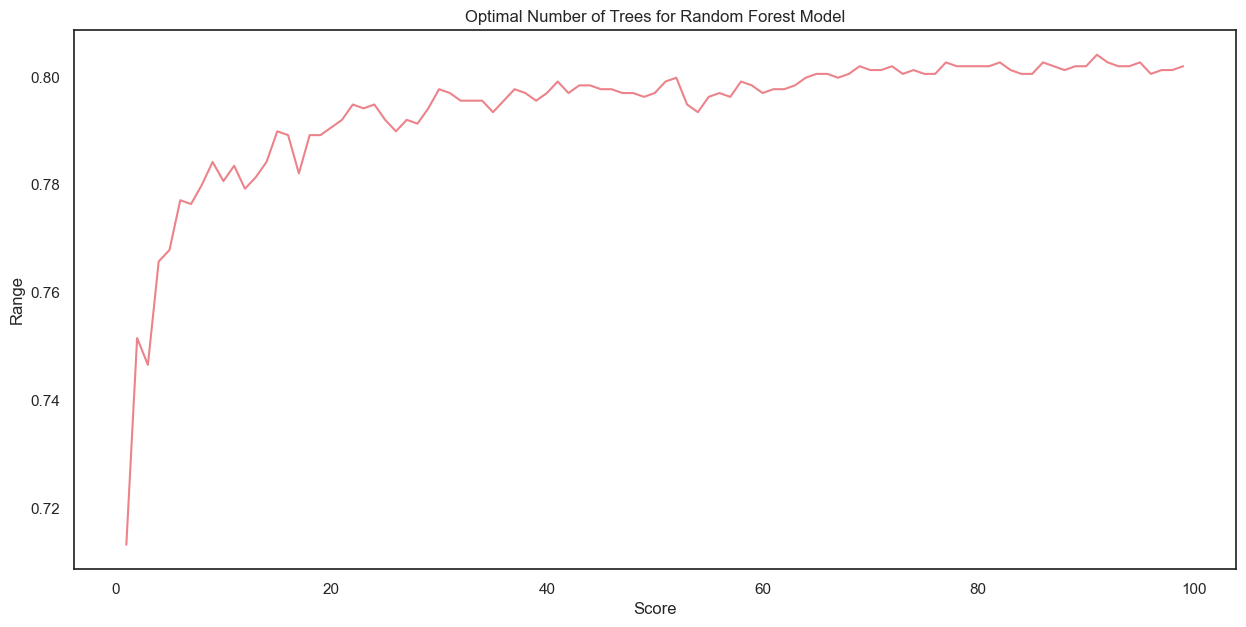

The most optimal trees is 91 with a value of 0.8041163946061036


In [88]:
score_array = []
for i in range(1, 100):
    rf_loop = RandomForestClassifier(n_estimators=i, criterion='entropy', random_state=1, n_jobs=-1)
    
    rf_loop.fit(train_X_pca, train_y)
    score_array.append(rf_loop.score(test_X_pca, test_y))
    
# Plot the accuracy results
fig = plt.figure(figsize=(15,7))
plt.plot(range(1, 100), score_array, color='#ec838a')

plt.ylabel('Range')
plt.xlabel('Score')
plt.title('Optimal Number of Trees for Random Forest Model')

plt.show()
print(f"The most optimal trees is {score_array.index(max(score_array))+1} with a value of {max(score_array)}")

### Compare baseline classification algorithms (2nd iteration)

We will now use the optimised parameters for KNN and Random Forest models. Since false negatives are more costly in a churn, let's use precision, recall and F2 scores as the ideal metric for model selection.

In [89]:
# Logistic Regression
lr = LogisticRegression(solver='liblinear', C=0.1, penalty='l2', random_state=0)
lr.fit(train_X_pca, train_y)

# Predicting test result
yhat = lr.predict(test_X_pca)

# Evaluate results
acc = accuracy_score(test_y, yhat)
prec = precision_score(test_y, yhat)
recall = recall_score(test_y, yhat)
f1 = recall_score(test_y, yhat)
f2 = fbeta_score(test_y, yhat, beta=2.0)

results = pd.DataFrame([['LogisticRegression', acc, prec, recall, f1, f2]], columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])

results= results.sort_values(["Precision", "Recall", "F2 Score"], ascending=False)

print(results)

                Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0  LogisticRegression  0.817601   0.688312  0.568365  0.568365  0.588889


In [90]:
# Linear SVM
linear_svm = SVC(kernel='linear', random_state=0)
linear_svm.fit(train_X_pca, train_y)

# Predicting test result
yhat = linear_svm.predict(test_X_pca)

# Evaluate results
acc = accuracy_score(test_y, yhat)
prec = precision_score(test_y, yhat)
recall = recall_score(test_y, yhat)
f1 = recall_score(test_y, yhat)
f2 = fbeta_score(test_y, yhat, beta=2.0)

model_results = pd.DataFrame([['SVM (Linear)', acc, prec, recall, f1, f2]], columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])
results = pd.concat([results, model_results], ignore_index = True)
results= results.sort_values(["Precision", "Recall", "F2 Score"], ascending=False)

print(results)

                Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0  LogisticRegression  0.817601   0.688312  0.568365  0.568365  0.588889
1        SVM (Linear)  0.819730   0.680851  0.600536  0.600536  0.615047


In [91]:
# K Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=12, metric='minkowski', p=2)
knn_model.fit(train_X_pca, train_y)

# Predicting test result
yhat = knn_model.predict(test_X_pca)

# Evaluate results
acc = accuracy_score(test_y, yhat)
prec = precision_score(test_y, yhat)
recall = recall_score(test_y, yhat)
f1 = recall_score(test_y, yhat)
f2 = fbeta_score(test_y, yhat, beta=2.0)

model_results = pd.DataFrame([['K-Nearest Neighbors', acc, prec, recall, f1, f2]], columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])
results = pd.concat([results, model_results], ignore_index = True)
results= results.sort_values(["Precision", "Recall", "F2 Score"], ascending=False)

print(results)

                 Model  Accuracy  Precision    Recall  F1 Score  F2 Score
2  K-Nearest Neighbors  0.804116   0.694779  0.463807  0.463807  0.496841
0   LogisticRegression  0.817601   0.688312  0.568365  0.568365  0.588889
1         SVM (Linear)  0.819730   0.680851  0.600536  0.600536  0.615047


In [92]:
# RBF SVM
rbf_svm = SVC(kernel='rbf', random_state=0)
rbf_svm.fit(train_X_pca, train_y)

# Predicting test result
yhat = rbf_svm.predict(test_X_pca)

# Evaluate results
acc = accuracy_score(test_y, yhat)
prec = precision_score(test_y, yhat)
recall = recall_score(test_y, yhat)
f1 = recall_score(test_y, yhat)
f2 = fbeta_score(test_y, yhat, beta=2.0)

model_results = pd.DataFrame([['RBF SVM', acc, prec, recall, f1, f2]], columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])
results = pd.concat([results, model_results], ignore_index = True)
results= results.sort_values(["Precision", "Recall", "F2 Score"], ascending=False)

print(results)

                 Model  Accuracy  Precision    Recall  F1 Score  F2 Score
3              RBF SVM  0.802697   0.697095  0.450402  0.450402  0.484709
0  K-Nearest Neighbors  0.804116   0.694779  0.463807  0.463807  0.496841
1   LogisticRegression  0.817601   0.688312  0.568365  0.568365  0.588889
2         SVM (Linear)  0.819730   0.680851  0.600536  0.600536  0.615047


In [93]:
# Naive Bayes
gauss_nb = GaussianNB()
gauss_nb.fit(train_X_pca, train_y)

# Predicting test result
yhat = gauss_nb.predict(test_X_pca)

# Evaluate results
acc = accuracy_score(test_y, yhat)
prec = precision_score(test_y, yhat)
recall = recall_score(test_y, yhat)
f1 = recall_score(test_y, yhat)
f2 = fbeta_score(test_y, yhat, beta=2.0)

model_results = pd.DataFrame([['Naive Bayes', acc, prec, recall, f1, f2]], columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])
results = pd.concat([results, model_results], ignore_index = True)
results= results.sort_values(["Precision", "Recall", "F2 Score"], ascending=False)

print(results)

                 Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0              RBF SVM  0.802697   0.697095  0.450402  0.450402  0.484709
1  K-Nearest Neighbors  0.804116   0.694779  0.463807  0.463807  0.496841
2   LogisticRegression  0.817601   0.688312  0.568365  0.568365  0.588889
3         SVM (Linear)  0.819730   0.680851  0.600536  0.600536  0.615047
4          Naive Bayes  0.718950   0.481775  0.815013  0.815013  0.715968


In [94]:
# Naive Bayes
tree = DecisionTreeClassifier(criterion='entropy', random_state=0)
tree.fit(train_X_pca, train_y)

# Predicting test result
yhat = tree.predict(test_X_pca)

# Evaluate results
acc = accuracy_score(test_y, yhat)
prec = precision_score(test_y, yhat)
recall = recall_score(test_y, yhat)
f1 = recall_score(test_y, yhat)
f2 = fbeta_score(test_y, yhat, beta=2.0)

model_results = pd.DataFrame([['Decision Tree', acc, prec, recall, f1, f2]], columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])
results = pd.concat([results, model_results], ignore_index = True)
results= results.sort_values(["Precision", "Recall", "F2 Score"], ascending=False)

print(results)

                 Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0              RBF SVM  0.802697   0.697095  0.450402  0.450402  0.484709
1  K-Nearest Neighbors  0.804116   0.694779  0.463807  0.463807  0.496841
2   LogisticRegression  0.817601   0.688312  0.568365  0.568365  0.588889
3         SVM (Linear)  0.819730   0.680851  0.600536  0.600536  0.615047
4          Naive Bayes  0.718950   0.481775  0.815013  0.815013  0.715968
5        Decision Tree  0.713982   0.460733  0.471850  0.471850  0.469584


In [95]:
# Random Forest
randomForest = RandomForestClassifier(n_estimators=91, criterion='entropy', random_state=0)
randomForest.fit(train_X_pca, train_y)

# Predicting test result
yhat = randomForest.predict(test_X_pca)

# Evaluate results
acc = accuracy_score(test_y, yhat)
prec = precision_score(test_y, yhat)
recall = recall_score(test_y, yhat)
f1 = recall_score(test_y, yhat)
f2 = fbeta_score(test_y, yhat, beta=2.0)

model_results = pd.DataFrame([['Random Forest Classifier', acc, prec, recall, f1, f2]], columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])
results = pd.concat([results, model_results], ignore_index = True)
results= results.sort_values(["Precision", "Recall", "F2 Score"], ascending=False)

print(results)

                      Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0                   RBF SVM  0.802697   0.697095  0.450402  0.450402  0.484709
1       K-Nearest Neighbors  0.804116   0.694779  0.463807  0.463807  0.496841
2        LogisticRegression  0.817601   0.688312  0.568365  0.568365  0.588889
6  Random Forest Classifier  0.801987   0.685039  0.466488  0.466488  0.498282
3              SVM (Linear)  0.819730   0.680851  0.600536  0.600536  0.615047
4               Naive Bayes  0.718950   0.481775  0.815013  0.815013  0.715968
5             Decision Tree  0.713982   0.460733  0.471850  0.471850  0.469584


#### __Observations:__
We want to find the churn of customers, so we evaluate the different scores:

- Recall: If our priority is minimizing false negatives, Naive Bayes (Recall: 0.815) and Logistic Regression (Recall: 0.798) perform best. These models prioritize identifying customers who are at risk of churning.

- Precision: If we want to ensure that most of the predicted customers actually churn, RBF SVM (Precision: 0.697) and K-Nearest Neighbors (Precision: 0.694) perform well. Precision is important if you have limited resources and want to focus on high-certainty churn predictions.

- F1 Score: For a balance between precision and recall, Logistic Regression (F1: 0.798) and Naive Bayes (F1: 0.815) are the best performers.

- F2 Score: If recall is more important than precision, as indicated by the F2 score (which weights recall higher), Logistic Regression (F2: 0.730) and Naive Bayes (F2: 0.716) perform best

__Conclusion:__ We want to ensure there is balance between precision and recall, so the best model looks to be Logistic Regression. While SVM Linear has the best accuracy, it does not excell in recall.

## Model Evaluation

Model evaluation is primarily done through K-Fold cross validation technique that primarily helps us to fix the variance. Variance problem occurs when we have good accuracy while running the model on training set and a test set but then the accuracy looks different when the model is run on another test set.

In order to fix the variance, k-fold cross-validation will split the model into k folds, and train the model on the subsets of the training dataset before testing on the test fold. This gives the flexibility to train model on all combination of the fold.

In [96]:
yhat = lr.predict(test_X_pca)

In [97]:
accuracies = cross_val_score(estimator=lr, X=train_X_pca, y=train_y, cv=10)

print("Logistic Regression Classifier Accuracy: %0.2f (+/- %0.2f)"  % (accuracies.mean(), accuracies.std() * 2))

Logistic Regression Classifier Accuracy: 0.80 (+/- 0.02)


Our cross-fold validation indicates there is an accuracy between 78% and 82% while running this model on any test set.

In [98]:
def plot_confusion_matrix(y, y_predict):
    """
    This function plots the confusion matrix by using a heat map
    """
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y, y_predict)
    ax = plt.subplot()
    sns.set(font_scale=1.0)
    sns.heatmap(cm, annot=True, ax=ax, fmt='g'); #annot=True to annotate the cells

    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticklabels(['No Churn', 'Churn'])
    ax.yaxis.set_ticklabels(['No Churn', 'Churn'])
    plt.show()

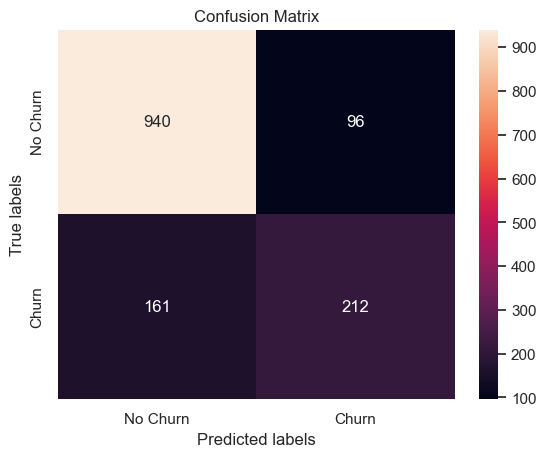

In [99]:
plot_confusion_matrix(test_y, yhat)

Examining the confusion matrix, we see that:

Overview:

True Positive - 940 (True label is No Churn, Predicted labels is also No Churn)

False Positives - 96 (True label is No Churn, Predicted labels is Churn)

We have 940+212 correct predictions, and 96+161 inaccurate predictions out of a total of 1409 predictions.

Accuracy rate = 1152 / 1409 * 100 = 81.76%
Error rate = 257 / 1409 * 100 = 18.24%

### Evaluating the ROC Graph

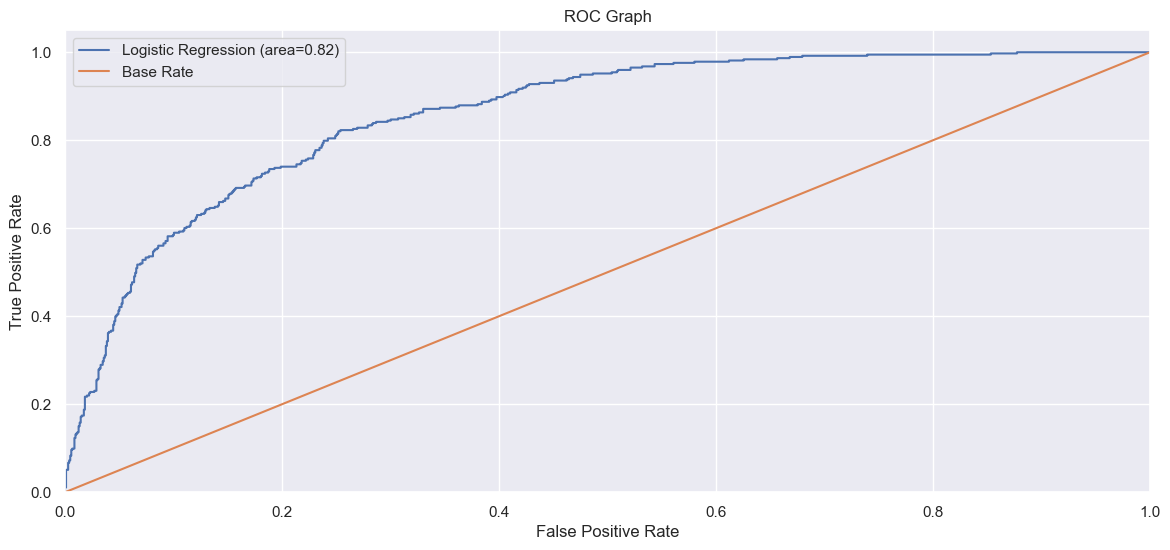

In [100]:
probs = lr.predict_proba(train_X_pca)
probs = probs[:,1]
lr_roc_auc = accuracy_score(test_y, yhat)

rf_fpr, rf_tpr, rf_thresholds = roc_curve(test_y, lr.predict_proba(test_X_pca)[:,1])
plt.figure(figsize=(14, 6))

# Plot Logistic Regression ROC AUC curve
plt.plot(rf_fpr, rf_tpr, label='Logistic Regression (area=%0.2f)'%lr_roc_auc)

# Plot base rate ROC
plt.plot([0,1], [0,1], label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.title('ROC Graph')

plt.legend(loc='upper left')
plt.show()

### Feature Importance

Although we have use PCA to remake new variables, we can still analyse the coefficients to understand their feature importance.

In [101]:
features_importance = pd.DataFrame({'Component': component_df.index.to_list(), 'Coefficient': [i for i in lr.coef_][0]})
features_importance.sort_values("Coefficient", ascending = False)

,Component,Coefficient
3,PC4,0.730218
15,PC16,0.173123
12,PC13,0.140616
6,PC7,0.092494
16,PC17,0.086370
7,PC8,0.049503
8,PC9,0.029106
14,PC15,0.025453
5,PC6,0.022482
9,PC10,-0.042947


We see that PC4 has the highest positive correlation compared to all others, followed by PC16 and PC13. Conversely, PC5, PC2, 1, and 3 are the most negatively correlated components.

### Model Improvement

To better optimise the model, we can look into choosing the best parameters for the machine learning. This can be done through parameter tuning techniques like Random Search or Grid Search.

In [102]:
# Use GridSearchCV to find best parameters for Logistic Regression
import time

parameters = {
    'C': [0.001, 0.01, 0.1 ,1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

lr = LogisticRegression()
logreg_cv = GridSearchCV(estimator=lr, param_grid=parameters, cv=10, scoring='balanced_accuracy')
t0 = time.time()

logreg_cv.fit(train_X_pca, train_y)
t1 = time.time()
print("Took 0.2%f seconds"%(t1-t0))

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

Took 0.215.713518 seconds
tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.7131679046399091


In [103]:
# Use GridSearchCV to find best parameters for Logistic Regression
# Round 2, remove penalty choice and update C
import time

parameters = {
    'C': [0.0001, 0.001, 0.01, 0.02, 0.05],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

lr = LogisticRegression()
logreg_cv = GridSearchCV(estimator=lr, param_grid=parameters, cv=10, scoring='balanced_accuracy', n_jobs=-1)
t0 = time.time()

logreg_cv.fit(train_X_pca, train_y)
t1 = time.time()
print("Took 0.2%f seconds"%(t1-t0))

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

Took 0.22.225913 seconds
tuned hpyerparameters :(best parameters)  {'C': 0.05, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.7119043770767817


In [104]:
# Use the hyper parametised model 
yhat_new = logreg_cv.predict(test_X_pca)

# Predict the Test set resultsy_pred = lr_classifier.predict(X_test)#probability score
y_pred_probs = logreg_cv.predict_proba(test_X_pca)
y_pred_probs  = y_pred_probs [:, 1]

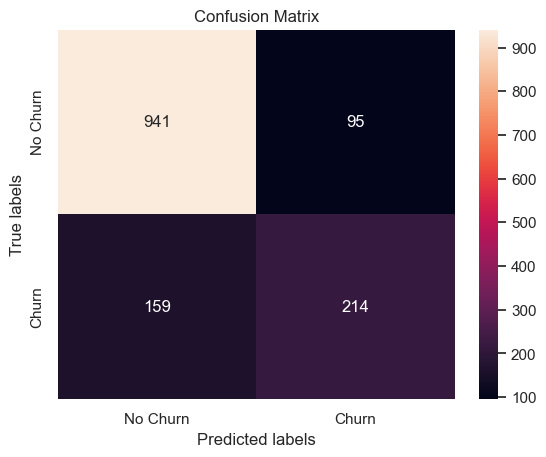

In [105]:
plot_confusion_matrix(test_y, yhat_new)

We see a slight improvement over the original Linear Regression model.

### Format Final results

Unpredictability and risk should always be introduced into any predictive models. Therefore, in the real world, it is always good practice to build up a propensity score besides an absolute predicted outcome. Instead of just being a binary estimated target outcome (0 or 1), every 'CustomerID' can get an additional layer of propensity score highlighting their percentage of probability to take action.

In [106]:
test_identity = dataset.iloc[test_X.index]['customerID']
final_results = pd.concat([test_identity, test_y], axis=1).dropna()

final_results['predictions'] = yhat_new
final_results['propensity_to_churn(%)'] = y_pred_probs
final_results['propensity_to_churn(%)'] = final_results['propensity_to_churn(%)'] * 100
final_results['propensity_to_churn(%)'] = final_results['propensity_to_churn(%)'].round(2)

final_results = final_results[['customerID', 'Churn', 'predictions', 'propensity_to_churn(%)']]
final_results ['Ranking'] = pd.qcut(final_results['propensity_to_churn(%)'].rank(method = 'first'),10,labels=range(10,0,-1))

final_results

,customerID,Churn,predictions,propensity_to_churn(%),Ranking
185,1024-GUALD,1,1,66.41,2
2715,0484-JPBRU,0,0,7.79,8
3825,3620-EHIMZ,0,0,1.55,10
1807,6910-HADCM,1,1,65.51,2
132,8587-XYZSF,0,0,1.64,10
...,...,...,...,...,...
6366,2845-KDHVX,0,0,2.27,10
315,5027-YOCXN,0,0,9.28,7
2439,8884-MRNSU,0,0,7.96,8
5002,0567-XRHCU,0,0,4.01,9


In [107]:
final_results.sort_values(['propensity_to_churn(%)', 'Ranking'], ascending=False )

,customerID,Churn,predictions,propensity_to_churn(%),Ranking
2208,7216-EWTRS,1,1,88.58,1
1410,7024-OHCCK,1,1,88.07,1
4800,9300-AGZNL,1,1,87.70,1
585,5192-EBGOV,1,1,85.60,1
3346,2545-EBUPK,0,1,85.57,1
...,...,...,...,...,...
4201,1166-PQLGG,0,0,0.84,10
764,7969-FFOWG,0,0,0.83,10
932,5787-KXGIY,0,0,0.80,10
5422,3563-SVYLG,0,0,0.74,10


### Deploy Model

We deploy the model to a server using 'joblib' library so we can productionize the end-to-end machine learning framework. Later we can run the model over any new dataset to predict the probability of any customer to churn in months to come.

In [ ]:
# save the model
filename = 'final_model.model'
i = [logreg_cv]
joblib.dump(i,filename)

## Credits

Thank you to Sreejith Sreedharan [Article|https://towardsdatascience.com/predict-customer-churn-in-python-e8cd6d3aaa7]